In [1]:
# =============================================================================
# IMPORTS - Complete setup for holographic pollen volume estimation
# =============================================================================

# Core Python libraries
import os
import re
from datetime import datetime
from typing import Tuple, Dict, List, Optional, Union

# Image processing and computer vision
from PIL import Image
import cv2
import numpy as np
from skimage import morphology, filters
from scipy.spatial import ConvexHull
from scipy.optimize import minimize

# Deep learning framework
import torch
from torch.utils.data import Dataset
from torchvision import transforms

# Data analysis and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style for better visualizations
plt.style.use("default")
sns.set_palette("husl")

print("✅ All imports loaded successfully!")
print("📊 Ready for holographic pollen volume estimation")
print("🔬 Notebook configured for scientific analysis")

✅ All imports loaded successfully!
📊 Ready for holographic pollen volume estimation
🔬 Notebook configured for scientific analysis


# 🔬 Holographic Pollen Volume Estimation - Complete Analysis

## 📋 **Notebook Overview**

This notebook provides a comprehensive solution for **3D pollen volume estimation** from two orthogonal 2D holographic images (binary masks). 

### **🎯 Main Features**

1. **5 Volume Estimation Methods**:
   - Simple Multiplication (baseline)
   - Ellipsoid Fitting (geometric)
   - Cross-sectional Integration (slice-based)
   - Voxel Reconstruction (3D space-filling)
   - **Rotational Body** (axis rotation) ⭐ **NEW**

2. **Enhanced Data Loading**:
   - Metadata extraction (pollen ID, datetime)
   - Mesh mapping for 3D reconstruction integration
   - Robust filename parsing

3. **Comprehensive Analysis**:
   - Batch processing pipeline
   - Statistical method comparisons
   - Visualization suite
   - CSV export functionality

### **📊 Expected Results**
- Volume estimates from multiple independent methods
- Statistical validation and correlation analysis
- Integration with existing 3D mesh reconstructions
- Complete analysis pipeline ready for production

### **🗂️ Notebook Structure**
1. **Setup & Imports** ← You are here
2. **Image Processing Classes** (Ripple filter, etc.)
3. **Dataset with Metadata** (Enhanced pollen dataset)
4. **Volume Estimator** (5 different methods)
5. **Visualization Functions** (Comprehensive plotting)
6. **Batch Analysis** (Process multiple samples)
7. **Mesh Integration** (3D reconstruction mapping)
8. **Final Results** (Summary and exports)

---

## Holographic Ripple Filter
The following class applies a PIL transform that
1) blurs to suppress noise
2) thresholds (Otsu or adaptive)
3) morphological-opens to knock out thin fringes
4) applies mask to original gray image, setting background to white
5) recenters & scales the object to fill the frame
6) finds the object bbox
7) scales it by up to `max_scale` (but no more than frame size)
8) pastes centered on white canvas

In [2]:
class RemoveRipples(object):
    def __init__(
        self,
        method: str = "otsu",
        blur_ksize: int = 5,
        adaptive_blocksize: int = 51,
        adaptive_C: int = 2,
        morph_ksize: int = 5,
        max_scale: float = 1.7,
    ):
        self.method = method.lower()
        self.blur_ksize = blur_ksize
        self.adaptive_blocksize = adaptive_blocksize
        self.adaptive_C = adaptive_C
        self.morph_ksize = morph_ksize
        self.max_scale = max_scale

        self._morph_kernel = cv2.getStructuringElement(
            cv2.MORPH_ELLIPSE, (self.morph_ksize, self.morph_ksize)
        )

    def __call__(self, img: Image.Image) -> Image.Image:
        orig = np.array(img.convert("L"), dtype=np.uint8)
        h, w = orig.shape

        # blur & threshold as before
        blur = cv2.GaussianBlur(orig, (self.blur_ksize,) * 2, 0)
        if self.method == "otsu":
            _, mask = cv2.threshold(
                blur, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU
            )
        else:
            mask = cv2.adaptiveThreshold(
                blur,
                255,
                cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY_INV,
                self.adaptive_blocksize,
                self.adaptive_C,
            )
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, self._morph_kernel)

        # apply mask
        result = np.where(mask == 255, orig, 255).astype(np.uint8)

        # find bbox of object
        ys, xs = np.where(result < 255)
        if len(xs) == 0 or len(ys) == 0:
            return Image.new("L", (w, h), color=255)

        y1, y2 = ys.min(), ys.max()
        x1, x2 = xs.min(), xs.max()
        crop = result[y1 : y2 + 1, x1 : x2 + 1]

        crop_h, crop_w = crop.shape
        max_by_frame = min(w / crop_w, h / crop_h)
        scale = min(self.max_scale, max_by_frame)

        new_w = int(crop_w * scale)
        new_h = int(crop_h * scale)

        # resize & paste
        crop_pil = Image.fromarray(crop, mode="L")
        resized = crop_pil.resize((new_w, new_h), resample=Image.LANCZOS)
        canvas = Image.new("L", (w, h), color=255)
        x_off = (w - new_w) // 2
        y_off = (h - new_h) // 2
        canvas.paste(resized, (x_off, y_off))

        return canvas

C:\Users\super\AppData\Local\Temp\ipykernel_14656\1517962255.py:19: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  gray_img = Image.fromarray(arr.astype(np.uint8), mode="L")
C:\Users\super\AppData\Local\Temp\ipykernel_14656\4277447103.py:63: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  crop_pil = Image.fromarray(crop, mode="L")


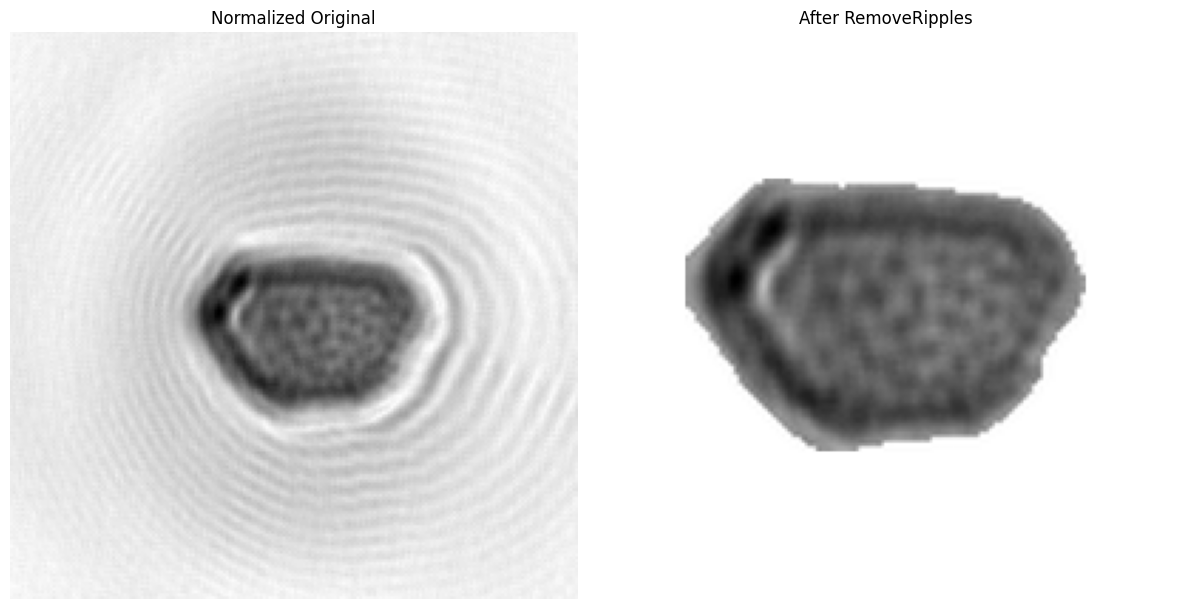

In [3]:
ripple_filter = RemoveRipples(
    method="otsu",
    blur_ksize=5,
    adaptive_blocksize=51,
    adaptive_C=2,
    morph_ksize=5,
    max_scale=1.7,
)

image_path = "../data/subset_poleno/g_carpinus_s_betulus/poleno-27_2023-04-06_18.06.28.175254_ev.computed_data.holography.image_pairs.0.0.rec_mag.png"

img = Image.open(image_path)
arr = np.array(img).astype(np.float32)
min_val, max_val = arr.min(), arr.max()
if max_val > min_val:
    arr = (arr - min_val) / (max_val - min_val) * 255.0
else:
    arr = np.zeros_like(arr)
gray_img = Image.fromarray(arr.astype(np.uint8), mode="L")

filtered_img = ripple_filter(gray_img)

orig_arr = np.array(gray_img)
filtered_arr = np.array(filtered_img)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(orig_arr, cmap="gray")
axes[0].set_title("Normalized Original")
axes[0].axis("off")

axes[1].imshow(filtered_arr, cmap="gray")
axes[1].set_title("After RemoveRipples")
axes[1].axis("off")

plt.tight_layout()
plt.show()

In [4]:
import os
import re
from datetime import datetime
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

# Assuming RemoveRipples is defined elsewhere
# from your_module import RemoveRipples


class HolographicPollenDataset(Dataset):
    def __init__(self, transform=None, extensions=None, mesh_dir=None):
        self.root_dir = os.path.join(os.getenv("DATA_DIR_PATH"), "subset_poleno")
        self.transform = transform
        self.extensions = extensions or [".png"]
        self.mesh_dir = mesh_dir  # Path to reconstructed meshes directory

        self.classes = sorted(
            [
                d
                for d in os.listdir(self.root_dir)
                if os.path.isdir(os.path.join(self.root_dir, d))
            ]
        )

        raw_samples = []
        for taxa in self.classes:
            cls_dir = os.path.join(self.root_dir, taxa)
            for fname in os.listdir(cls_dir):
                if any(fname.lower().endswith(ext) for ext in self.extensions):
                    path = os.path.join(cls_dir, fname)
                    raw_samples.append((path, taxa))

        groups = {}
        for path, taxa in raw_samples:
            fname = os.path.basename(path)
            if "image_pairs" not in fname:
                continue
            base = fname.split("image_pairs")[0]
            groups.setdefault((base, taxa), []).append(path)

        # Build pairs list with metadata
        self.pairs = []  # (path0, path1, taxa_name, metadata)
        for (base, taxa), paths in groups.items():
            p0 = next((p for p in paths if ".0." in os.path.basename(p)), None)
            p1 = next((p for p in paths if ".1." in os.path.basename(p)), None)

            if p0 and p1:
                # Extract metadata from filename
                metadata = self._extract_metadata(os.path.basename(p0))
                self.pairs.append((p0, p1, taxa, metadata))

    def _extract_metadata(self, filename):
        """
        Extract metadata from filename.
        Expected format: poleno-27_2023-04-06_18.06.28.175254_ev.computed_data.holography.image_pairs.0.0.rec_mag.png
        """
        metadata = {
            "filename": filename,
            "datetime_str": None,
            "datetime_obj": None,
            "pollen_id": None,
            "mesh_identifier": None,
        }

        # Extract pollen ID (e.g., "poleno-27")
        pollen_match = re.search(r"poleno-(\d+)", filename)
        if pollen_match:
            metadata["pollen_id"] = f"poleno-{pollen_match.group(1)}"

        # Extract datetime string (e.g., "2023-04-06_18.06.28.175254")
        datetime_pattern = r"(\d{4}-\d{2}-\d{2}_\d{2}\.\d{2}\.\d{2}\.\d+)"
        datetime_match = re.search(datetime_pattern, filename)
        if datetime_match:
            datetime_str = datetime_match.group(1)
            metadata["datetime_str"] = datetime_str

            # Convert to datetime object
            try:
                # Parse the datetime string
                # Format: 2023-04-06_18.06.28.175254
                date_part, time_part = datetime_str.split("_")
                time_clean = time_part.replace(".", ":")

                # Handle microseconds (last part after the seconds)
                if time_clean.count(":") > 2:
                    time_parts = time_clean.split(":")
                    time_clean = ":".join(
                        time_parts[:3]
                    )  # Keep only hours:minutes:seconds
                    microseconds = int(time_parts[3])
                else:
                    microseconds = 0

                dt_str = f"{date_part} {time_clean}"
                dt_obj = datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S")
                if microseconds:
                    dt_obj = dt_obj.replace(microsecond=microseconds)

                metadata["datetime_obj"] = dt_obj

            except ValueError as e:
                print(f"Warning: Could not parse datetime from {datetime_str}: {e}")

        # Create mesh identifier for mapping to OBJ files
        if metadata["pollen_id"] and metadata["datetime_str"]:
            metadata["mesh_identifier"] = (
                f"{metadata['pollen_id']}_{metadata['datetime_str']}"
            )

        return metadata

    def get_mesh_path(self, idx):
        """
        Get the corresponding mesh file path for a given index.
        """
        if not self.mesh_dir or not os.path.exists(self.mesh_dir):
            return None

        _, _, taxa, metadata = self.pairs[idx]
        datetime_str = metadata.get("datetime_str")
        if not datetime_str:
            return None

        # Simple approach: find any mesh file containing the datetime string
        try:
            for filename in os.listdir(self.mesh_dir):
                if filename.lower().endswith(".obj") and datetime_str in filename:
                    mesh_path = os.path.join(self.mesh_dir, filename)
                    if os.path.exists(mesh_path):
                        return mesh_path
        except:
            pass

        return None

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        path0, path1, taxa, metadata = self.pairs[idx]

        def load_and_normalize(p):
            img = Image.open(p)
            arr = np.array(img).astype(np.float32)
            mn, mx = arr.min(), arr.max()
            if mx > mn:
                arr = (arr - mn) / (mx - mn) * 255.0
            else:
                arr = np.zeros_like(arr)
            return Image.fromarray(arr.astype(np.uint8), mode="L")

        img0 = load_and_normalize(path0)
        img1 = load_and_normalize(path1)

        if self.transform:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        # Return images, taxa, and metadata
        return (img0, img1), taxa, metadata


# Create dataset with mesh directory support
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        RemoveRipples(
            method="otsu",
            blur_ksize=5,
            adaptive_blocksize=51,
            adaptive_C=2,
            morph_ksize=5,
        ),
        transforms.ToTensor(),
    ]
)

# Initialize dataset with mesh directory
mesh_directory = r"C:\Users\super\Documents\Github\sequoia\Pixel_Nerf\Pixel_Nerf\reconstructed\pollen_augmentation2"
dataset = HolographicPollenDataset(
    transform=transform,
    mesh_dir=mesh_directory if os.path.exists(mesh_directory) else None,
)

In [5]:
import os
import torch

# Assuming dataset is already defined and extended with metadata
# Test the extended dataset functionality
sample_idx = 0
(img0, img1), taxa, metadata = dataset[sample_idx]

print(f"Sample {sample_idx}:")
print(f"Taxa: {taxa}")
print(f"Pollen ID: {metadata['pollen_id']}")
print(f"Datetime string: {metadata['datetime_str']}")
print(f"Datetime object: {metadata['datetime_obj']}")
print(f"Mesh identifier: {metadata['mesh_identifier']}")
print(f"Filename: {metadata['filename']}")

# Check if corresponding mesh exists
mesh_path = dataset.get_mesh_path(sample_idx)
print(f"Mesh path: {mesh_path}")
print(
    f"Mesh exists: {mesh_path and os.path.exists(mesh_path) if mesh_path else 'No mesh directory configured'}"
)

# Check if the two images in the pair are equal
print(f"Images equal: {torch.all(img0 == img1)}")
print(f"Image shapes: {img0.shape}, {img1.shape}")

Sample 0:
Taxa: g_carpinus_s_betulus
Pollen ID: poleno-27
Datetime string: 2023-04-06_18.06.27.896254
Datetime object: 2023-04-06 18:06:27.896254
Mesh identifier: poleno-27_2023-04-06_18.06.27.896254
Filename: poleno-27_2023-04-06_18.06.27.896254_ev.computed_data.holography.image_pairs.0.0.rec_mag.png
Mesh path: None
Mesh exists: No mesh directory configured
Images equal: False
Image shapes: torch.Size([1, 224, 224]), torch.Size([1, 224, 224])


C:\Users\super\AppData\Local\Temp\ipykernel_14656\2648346897.py:153: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr.astype(np.uint8), mode="L")
C:\Users\super\AppData\Local\Temp\ipykernel_14656\4277447103.py:63: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  crop_pil = Image.fromarray(crop, mode="L")


C:\Users\super\AppData\Local\Temp\ipykernel_14656\2648346897.py:153: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr.astype(np.uint8), mode="L")
C:\Users\super\AppData\Local\Temp\ipykernel_14656\4277447103.py:63: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  crop_pil = Image.fromarray(crop, mode="L")


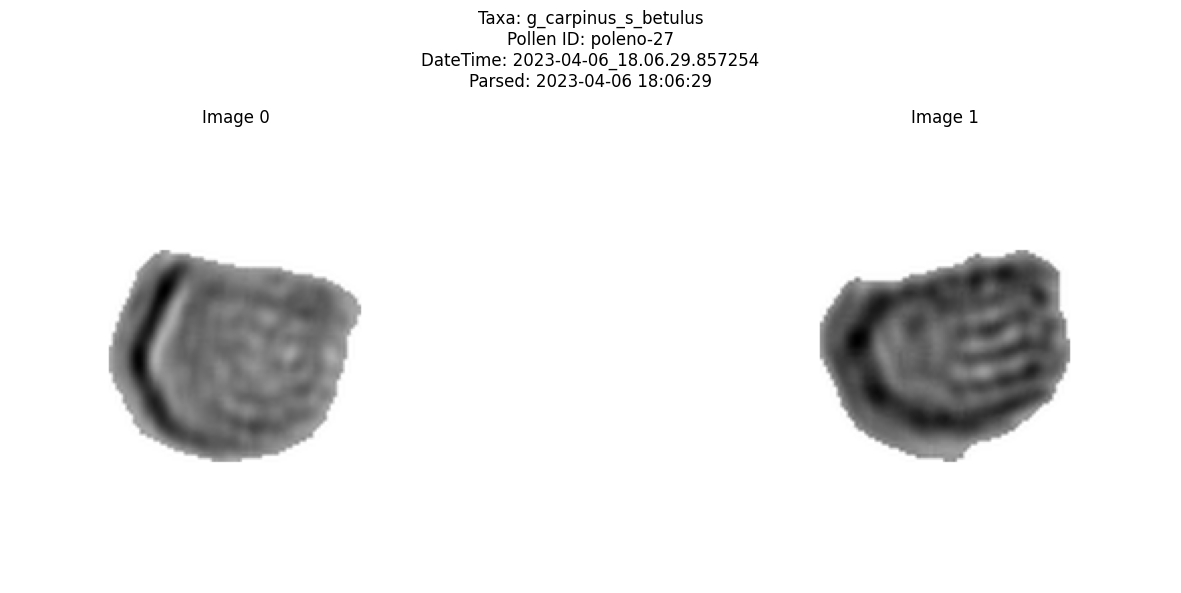

Mesh identifier: poleno-27_2023-04-06_18.06.29.857254
Expected mesh path: None
Mesh file exists: N/A


In [6]:
import matplotlib.pyplot as plt
import os

# Assuming dataset is already defined and loaded

# Visualize a sample with metadata
x = min(10, len(dataset) - 1)  # Ensure we don't go out of bounds

(img0, img1), taxa, metadata = dataset[x]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].imshow(img0.numpy().transpose(1, 2, 0), cmap="gray")
axes[0].set_title("Image 0")
axes[0].axis("off")

axes[1].imshow(img1.numpy().transpose(1, 2, 0), cmap="gray")
axes[1].set_title("Image 1")
axes[1].axis("off")

# Create detailed title with metadata
title = f"Taxa: {taxa}\nPollen ID: {metadata['pollen_id']}\nDateTime: {metadata['datetime_str']}"
if metadata["datetime_obj"]:
    title += f"\nParsed: {metadata['datetime_obj'].strftime('%Y-%m-%d %H:%M:%S')}"

fig.suptitle(title, fontsize=12)
plt.tight_layout()
plt.show()

# Show mesh mapping information
mesh_path = dataset.get_mesh_path(x)
print(f"Mesh identifier: {metadata['mesh_identifier']}")
print(f"Expected mesh path: {mesh_path}")
print(
    f"Mesh file exists: {mesh_path and os.path.exists(mesh_path) if mesh_path else 'N/A'}"
)

In [7]:
# Create overview of all samples and their metadata
import pandas as pd


def create_dataset_overview(dataset, max_samples=None):
    """Create a pandas DataFrame with dataset overview including metadata."""
    data = []

    num_samples = min(max_samples, len(dataset)) if max_samples else len(dataset)

    for i in range(num_samples):
        try:
            (img0, img1), taxa, metadata = dataset[i]

            # Check for mesh file
            mesh_path = dataset.get_mesh_path(i)
            mesh_exists = (
                mesh_path and os.path.exists(mesh_path) if mesh_path else False
            )

            data.append(
                {
                    "Index": i,
                    "Taxa": taxa,
                    "Pollen_ID": metadata["pollen_id"],
                    "DateTime_String": metadata["datetime_str"],
                    "DateTime_Parsed": (
                        metadata["datetime_obj"].strftime("%Y-%m-%d %H:%M:%S")
                        if metadata["datetime_obj"]
                        else None
                    ),
                    "Mesh_Identifier": metadata["mesh_identifier"],
                    "Mesh_Path": mesh_path,
                    "Mesh_Exists": mesh_exists,
                    "Filename": metadata["filename"],
                }
            )
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            continue

    return pd.DataFrame(data)


# Create overview for first 20 samples
print("Creating dataset overview...")
overview_df = create_dataset_overview(dataset, max_samples=20)

print(f"\nDataset Overview ({len(overview_df)} samples):")
print("=" * 80)

# Display basic statistics
print(f"Total samples: {len(dataset)}")
print(f"Unique taxa: {overview_df['Taxa'].nunique()}")
print(f"Taxa distribution:")
print(overview_df["Taxa"].value_counts())

print(f"\nDateTime range:")
if overview_df["DateTime_Parsed"].notna().any():
    valid_dates = pd.to_datetime(overview_df["DateTime_Parsed"].dropna())
    print(f"  From: {valid_dates.min()}")
    print(f"  To: {valid_dates.max()}")

print(f"\nMesh file availability:")
if "Mesh_Exists" in overview_df.columns:
    mesh_stats = overview_df["Mesh_Exists"].value_counts()
    print(f"  Available: {mesh_stats.get(True, 0)}")
    print(f"  Missing: {mesh_stats.get(False, 0)}")
else:
    print("  Mesh directory not configured")

# Display first few rows
print(f"\nFirst 10 samples:")
print(
    overview_df[["Index", "Taxa", "Pollen_ID", "DateTime_String", "Mesh_Exists"]]
    .head(10)
    .to_string(index=False)
)

# Save overview to CSV for further analysis
csv_path = "dataset_overview.csv"
overview_df.to_csv(csv_path, index=False)
print(f"\nOverview saved to: {csv_path}")

Creating dataset overview...

Dataset Overview (20 samples):
Total samples: 3434
Unique taxa: 1
Taxa distribution:
Taxa
g_carpinus_s_betulus    20
Name: count, dtype: int64

DateTime range:
  From: 2023-04-06 18:06:27
  To: 2023-04-06 18:06:31

Mesh file availability:
  Available: 3
  Missing: 17

First 10 samples:
 Index                 Taxa Pollen_ID            DateTime_String  Mesh_Exists
     0 g_carpinus_s_betulus poleno-27 2023-04-06_18.06.27.896254        False
     1 g_carpinus_s_betulus poleno-27 2023-04-06_18.06.28.175254         True
     2 g_carpinus_s_betulus poleno-27 2023-04-06_18.06.28.401254         True
     3 g_carpinus_s_betulus poleno-27 2023-04-06_18.06.28.773254        False
     4 g_carpinus_s_betulus poleno-27 2023-04-06_18.06.28.963254         True
     5 g_carpinus_s_betulus poleno-27 2023-04-06_18.06.29.066254        False
     6 g_carpinus_s_betulus poleno-27 2023-04-06_18.06.29.322254        False
     7 g_carpinus_s_betulus poleno-27 2023-04-06_18.06.29.6

C:\Users\super\AppData\Local\Temp\ipykernel_14656\2648346897.py:153: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr.astype(np.uint8), mode="L")
C:\Users\super\AppData\Local\Temp\ipykernel_14656\4277447103.py:63: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  crop_pil = Image.fromarray(crop, mode="L")


In [8]:
import sys

# move out of the current directory
sys.path.append("../")

from data import HolographicPolenoDataModule

In [9]:
datamodule = HolographicPolenoDataModule(
    batch_size=3, num_workers=0, image_transforms=transform
)

In [10]:
datamodule.setup("test")

for batch in datamodule.test_dataloader():
    print(batch[0][0].shape, batch[1])

torch.Size([3, 1, 224, 224]) ('g_carpinus_s_betulus', 'g_carpinus_s_betulus', 'g_carpinus_s_betulus')
torch.Size([3, 1, 224, 224]) ('g_fagus_s_sylvatica', 'g_fagus_s_sylvatica', 'g_fagus_s_sylvatica')
torch.Size([3, 1, 224, 224]) ('g_olea_s_europaea', 'g_olea_s_europaea', 'g_olea_s_europaea')
torch.Size([3, 1, 224, 224]) ('g_parietaria_s_officinalis', 'g_parietaria_s_officinalis', 'g_parietaria_s_officinalis')
torch.Size([3, 1, 224, 224]) ('g_picea_s_abies', 'g_picea_s_abies', 'g_picea_s_abies')
torch.Size([3, 1, 224, 224]) ('g_rumex_s_acetosella', 'g_rumex_s_acetosella', 'g_rumex_s_acetosella')
torch.Size([3, 1, 224, 224]) ('g_urtica_s_dioica', 'g_urtica_s_dioica', 'g_urtica_s_dioica')


C:\Users\super\AppData\Local\Temp\ipykernel_14656\4277447103.py:63: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  crop_pil = Image.fromarray(crop, mode="L")


# Volume Estimation from Two Orthogonal Images

When we have two orthogonal 2D projections (Image 0 and Image 1), we can estimate the 3D volume of the pollen grain using several approaches:

1. **Convex Hull Method**: Find the convex hull of each 2D projection and combine them
2. **Ellipsoid Approximation**: Fit ellipses to each projection and create a 3D ellipsoid
3. **Cross-sectional Integration**: Use the silhouettes to estimate volume through integration
4. **Voxel-based Reconstruction**: Create a 3D voxel grid and fill based on projections

Let's implement these methods to compare their effectiveness.

In [11]:
import scipy.spatial
from scipy import ndimage
from skimage import measure, morphology, segmentation
from skimage.feature import canny
from sklearn.cluster import DBSCAN
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

In [12]:
def extract_object_silhouette(img_array, threshold=127):
    """
    Extract the object silhouette from a grayscale image.

    Args:
        img_array: 2D numpy array (grayscale image)
        threshold: threshold value to create binary mask

    Returns:
        binary_mask: 2D boolean array where True = object, False = background
        contour_points: List of (x, y) points defining the object boundary
    """
    # Create binary mask (object = True, background = False)
    binary_mask = img_array < threshold  # Assuming object is dark, background is light

    # Clean up the mask using morphological operations
    binary_mask = morphology.remove_small_objects(binary_mask, min_size=100)
    binary_mask = morphology.remove_small_holes(binary_mask, area_threshold=100)
    binary_mask = morphology.binary_closing(binary_mask, morphology.disk(3))

    # Find contours
    contours = measure.find_contours(binary_mask.astype(float), 0.5)

    if not contours:
        return binary_mask, []

    # Take the largest contour (main object)
    largest_contour = max(contours, key=len)
    contour_points = [
        (int(point[1]), int(point[0])) for point in largest_contour
    ]  # (x, y) format

    return binary_mask, contour_points


def get_convex_hull_2d(contour_points):
    """
    Get the convex hull of 2D contour points.

    Args:
        contour_points: List of (x, y) tuples

    Returns:
        hull_points: Array of hull points
        hull_area: Area of the convex hull
    """
    if len(contour_points) < 3:
        return np.array([]), 0

    points = np.array(contour_points)
    hull = scipy.spatial.ConvexHull(points)
    hull_points = points[hull.vertices]
    hull_area = hull.volume  # In 2D, volume gives area

    return hull_points, hull_area

In [13]:
class VolumeEstimator:
    """Class for estimating 3D volume from two orthogonal 2D projections."""

    def __init__(self, pixel_size=1.0):
        """
        Initialize volume estimator.

        Args:
            pixel_size: Real-world size of one pixel (e.g., micrometers)
        """
        self.pixel_size = pixel_size

    def method_1_simple_multiplication(self, img1, img2, threshold=127):
        """
        Method 1: Simple area multiplication (rough approximation).
        Volume ≈ sqrt(Area1 * Area2) * average_diameter
        """
        mask1, _ = extract_object_silhouette(img1, threshold)
        mask2, _ = extract_object_silhouette(img2, threshold)

        area1 = np.sum(mask1) * (self.pixel_size**2)
        area2 = np.sum(mask2) * (self.pixel_size**2)

        # Estimate characteristic length from areas
        char_length1 = np.sqrt(area1)
        char_length2 = np.sqrt(area2)
        avg_char_length = (char_length1 + char_length2) / 2

        # Simple volume approximation
        volume = np.sqrt(area1 * area2) * avg_char_length

        return volume, {"area1": area1, "area2": area2, "char_length": avg_char_length}

    def method_2_ellipsoid_fitting(self, img1, img2, threshold=127):
        """
        Method 2: Fit ellipses to each projection and create 3D ellipsoid.
        """
        mask1, contour1 = extract_object_silhouette(img1, threshold)
        mask2, contour2 = extract_object_silhouette(img2, threshold)

        def fit_ellipse_to_contour(contour_points):
            if len(contour_points) < 5:
                return None

            points = np.array(contour_points)

            # Fit ellipse using second moments
            x = points[:, 0]
            y = points[:, 1]

            # Calculate centroid
            cx = np.mean(x)
            cy = np.mean(y)

            # Center the points
            x_c = x - cx
            y_c = y - cy

            # Calculate second moments
            xx = np.mean(x_c * x_c)
            yy = np.mean(y_c * y_c)
            xy = np.mean(x_c * y_c)

            # Eigenvalues give the semi-axes lengths
            trace = xx + yy
            det = xx * yy - xy * xy

            if det <= 0:
                return None

            sqrt_term = np.sqrt((trace / 2) ** 2 - det)
            a = np.sqrt(2 * (trace / 2 + sqrt_term))  # Semi-major axis
            b = np.sqrt(2 * (trace / 2 - sqrt_term))  # Semi-minor axis

            return a, b, cx, cy

        ellipse1 = fit_ellipse_to_contour(contour1)
        ellipse2 = fit_ellipse_to_contour(contour2)

        if ellipse1 is None or ellipse2 is None:
            return 0, {"error": "Could not fit ellipses"}

        a1, b1, cx1, cy1 = ellipse1
        a2, b2, cx2, cy2 = ellipse2

        # Create 3D ellipsoid: assume orthogonal projections
        # Use the larger axis from each projection as two of the ellipsoid axes
        # The third axis is estimated from the smaller axes
        axes = [max(a1, b1), max(a2, b2), np.sqrt(min(a1, b1) * min(a2, b2))]
        axes = [ax * self.pixel_size for ax in axes]

        # Volume of ellipsoid: (4/3) * π * a * b * c
        volume = (4 / 3) * np.pi * axes[0] * axes[1] * axes[2]

        return volume, {
            "ellipse1": ellipse1,
            "ellipse2": ellipse2,
            "axes": axes,
            "pixel_size": self.pixel_size,
        }

    def method_3_cross_sectional_integration(
        self, img1, img2, threshold=127, num_slices=50
    ):
        """
        Method 3: Cross-sectional integration using both projections.
        """
        mask1, _ = extract_object_silhouette(img1, threshold)
        mask2, _ = extract_object_silhouette(img2, threshold)

        h1, w1 = mask1.shape
        h2, w2 = mask2.shape

        # For each slice along one dimension, estimate the cross-sectional area
        volume = 0

        # Integrate along the height dimension
        for i in range(max(h1, h2)):
            # Get width profiles from both projections
            if i < h1:
                width1 = np.sum(mask1[i, :])
            else:
                width1 = 0

            if i < h2:
                width2 = np.sum(mask2[i, :])
            else:
                width2 = 0

            # Estimate cross-sectional area (elliptical approximation)
            if width1 > 0 and width2 > 0:
                # Area of ellipse with semi-axes width1/2 and width2/2
                cross_section_area = np.pi * (width1 / 2) * (width2 / 2)
                volume += cross_section_area

        volume *= self.pixel_size**3

        return volume, {"num_slices": num_slices, "method": "cross_sectional"}

    def method_4_voxel_reconstruction(
        self, img1, img2, threshold=127, voxel_resolution=64
    ):
        """
        Method 4: 3D voxel-based reconstruction.
        Create a 3D volume and mark voxels as occupied if they project
        onto object pixels in both 2D images.
        """
        mask1, _ = extract_object_silhouette(img1, threshold)
        mask2, _ = extract_object_silhouette(img2, threshold)

        h1, w1 = mask1.shape
        h2, w2 = mask2.shape

        # Create 3D voxel grid
        # Assume orthogonal projections: img1 = XY plane, img2 = XZ plane
        max_dim = max(h1, w1, h2, w2)
        voxel_grid = np.zeros(
            (voxel_resolution, voxel_resolution, voxel_resolution), dtype=bool
        )

        # Scale factors
        scale_x = voxel_resolution / max_dim
        scale_y = voxel_resolution / max_dim
        scale_z = voxel_resolution / max_dim

        # Fill voxels
        for x in range(voxel_resolution):
            for y in range(voxel_resolution):
                for z in range(voxel_resolution):
                    # Map voxel coordinates back to image coordinates
                    img1_x = int(x / scale_x)
                    img1_y = int(y / scale_y)
                    img2_x = int(x / scale_x)
                    img2_z = int(z / scale_z)

                    # Check if this voxel projects onto object in both images
                    in_obj1 = (
                        0 <= img1_x < w1 and 0 <= img1_y < h1 and mask1[img1_y, img1_x]
                    )
                    in_obj2 = (
                        0 <= img2_x < w2 and 0 <= img2_z < h2 and mask2[img2_z, img2_x]
                    )

                    voxel_grid[x, y, z] = in_obj1 and in_obj2

        # Count occupied voxels
        num_voxels = np.sum(voxel_grid)
        voxel_size = (max_dim * self.pixel_size / voxel_resolution) ** 3
        volume = num_voxels * voxel_size

        return volume, {
            "voxel_grid": voxel_grid,
            "num_voxels": num_voxels,
            "voxel_size": voxel_size,
            "resolution": voxel_resolution,
        }

    def method_5_rotational_body(
        self, img1, img2, threshold=127, rotation_axis="vertical"
    ):
        """
        Method 5: Rotational body approximation.
        Uses width and height from orthogonal projections to approximate volume
        by rotating one projection around an axis.

        Args:
            img1, img2: Input images (orthogonal projections)
            threshold: Binary threshold for mask extraction
            rotation_axis: 'vertical', 'horizontal', or 'ellipsoid' (default approximation)
        """
        mask1, _ = extract_object_silhouette(img1, threshold)
        mask2, _ = extract_object_silhouette(img2, threshold)

        # Get dimensions of both projections
        h1, w1 = mask1.shape
        h2, w2 = mask2.shape

        # Find bounding box dimensions for both projections
        def get_object_dimensions(mask):
            if not np.any(mask):
                return 0, 0

            # Find bounding box
            rows = np.any(mask, axis=1)
            cols = np.any(mask, axis=0)

            if not np.any(rows) or not np.any(cols):
                return 0, 0

            rmin, rmax = np.where(rows)[0][[0, -1]]
            cmin, cmax = np.where(cols)[0][[0, -1]]

            height = (rmax - rmin + 1) * self.pixel_size
            width = (cmax - cmin + 1) * self.pixel_size

            return height, width

        height1, width1 = get_object_dimensions(mask1)
        height2, width2 = get_object_dimensions(mask2)

        if height1 == 0 or width1 == 0 or height2 == 0 or width2 == 0:
            return 0, {"error": "Could not determine object dimensions"}

        # Calculate volume using rotational body approximation
        if rotation_axis == "vertical":
            # Rotate around vertical axis - use average width as radius
            radius = (width1 + width2) / 4  # Average width, divided by 2 for radius
            height = (height1 + height2) / 2  # Average height

            # For better approximation, consider the shape variation along height
            # Calculate volume by integrating circular cross-sections
            volume = 0
            num_slices = max(int(height / self.pixel_size), 1)

            for i in range(num_slices):
                # Height fraction
                h_frac = i / num_slices if num_slices > 1 else 0.5

                # Get width at this height from both projections
                h_idx1 = int(h_frac * h1)
                h_idx2 = int(h_frac * h2)

                width_at_h1 = (
                    np.sum(mask1[h_idx1, :]) * self.pixel_size if h_idx1 < h1 else 0
                )
                width_at_h2 = (
                    np.sum(mask2[h_idx2, :]) * self.pixel_size if h_idx2 < h2 else 0
                )

                if width_at_h1 > 0 and width_at_h2 > 0:
                    # Use geometric mean of widths as diameter, then radius
                    avg_width = np.sqrt(width_at_h1 * width_at_h2)
                    radius_at_h = avg_width / 2

                    # Add volume of thin disk
                    slice_volume = np.pi * radius_at_h**2 * (height / num_slices)
                    volume += slice_volume

        elif rotation_axis == "horizontal":
            # Rotate around horizontal axis - use average height as radius
            radius = (height1 + height2) / 4  # Average height, divided by 2 for radius
            width = (width1 + width2) / 2  # Average width (length of rotation)

            # Calculate volume by integrating circular cross-sections along width
            volume = 0
            num_slices = max(int(width / self.pixel_size), 1)

            for i in range(num_slices):
                # Width fraction
                w_frac = i / num_slices if num_slices > 1 else 0.5

                # Get height at this width from both projections
                w_idx1 = int(w_frac * w1)
                w_idx2 = int(w_frac * w2)

                height_at_w1 = (
                    np.sum(mask1[:, w_idx1]) * self.pixel_size if w_idx1 < w1 else 0
                )
                height_at_w2 = (
                    np.sum(mask2[:, w_idx2]) * self.pixel_size if w_idx2 < w2 else 0
                )

                if height_at_w1 > 0 and height_at_w2 > 0:
                    # Use geometric mean of heights as diameter, then radius
                    avg_height = np.sqrt(height_at_w1 * height_at_w2)
                    radius_at_w = avg_height / 2

                    # Add volume of thin disk
                    slice_volume = np.pi * radius_at_w**2 * (width / num_slices)
                    volume += slice_volume

        else:
            # Default: ellipsoid approximation using all dimensions
            a = width1 / 2  # Semi-axis from projection 1
            b = width2 / 2  # Semi-axis from projection 2
            c = (height1 + height2) / 4  # Average height as third semi-axis

            volume = (4 / 3) * np.pi * a * b * c

        return volume, {
            "dimensions1": (height1, width1),
            "dimensions2": (height2, width2),
            "rotation_axis": rotation_axis,
            "method": "rotational_body",
        }

In [14]:
def visualize_volume_estimation(img1, img2, estimator, threshold=127):
    """
    Visualize the volume estimation process for two orthogonal images.
    """
    # Convert tensor to numpy if needed
    if hasattr(img1, "numpy"):
        img1 = img1.numpy()
    if hasattr(img2, "numpy"):
        img2 = img2.numpy()

    # If images are 3D (C, H, W), take the first channel
    if len(img1.shape) == 3:
        img1 = img1[0]
    if len(img2.shape) == 3:
        img2 = img2[0]

    # Convert to uint8 if needed
    if img1.dtype != np.uint8:
        img1 = (img1 * 255).astype(np.uint8)
    if img2.dtype != np.uint8:
        img2 = (img2 * 255).astype(np.uint8)

    # Extract silhouettes
    mask1, contour1 = extract_object_silhouette(img1, threshold)
    mask2, contour2 = extract_object_silhouette(img2, threshold)

    # Get convex hulls
    hull1, area1 = get_convex_hull_2d(contour1)
    hull2, area2 = get_convex_hull_2d(contour2)

    # Estimate volumes using all methods
    vol1, info1 = estimator.method_1_simple_multiplication(img1, img2, threshold)
    vol2, info2 = estimator.method_2_ellipsoid_fitting(img1, img2, threshold)
    vol3, info3 = estimator.method_3_cross_sectional_integration(img1, img2, threshold)
    vol4, info4 = estimator.method_4_voxel_reconstruction(img1, img2, threshold)
    vol5, info5 = estimator.method_5_rotational_body(img1, img2, threshold, "vertical")

    # Create visualization
    fig = plt.figure(figsize=(24, 12))

    # Original images with contours and hulls
    ax1 = plt.subplot(2, 5, 1)
    plt.imshow(img1, cmap="gray")
    if len(contour1) > 0:
        contour_array = np.array(contour1)
        plt.plot(
            contour_array[:, 0], contour_array[:, 1], "r-", linewidth=2, label="Contour"
        )
    if len(hull1) > 0:
        hull_closed = np.vstack([hull1, hull1[0]])
        plt.plot(
            hull_closed[:, 0],
            hull_closed[:, 1],
            "b--",
            linewidth=2,
            label="Convex Hull",
        )
    plt.title("Image 1 (Projection 1)")
    plt.legend()
    plt.axis("off")

    ax2 = plt.subplot(2, 5, 2)
    plt.imshow(img2, cmap="gray")
    if len(contour2) > 0:
        contour_array = np.array(contour2)
        plt.plot(
            contour_array[:, 0], contour_array[:, 1], "r-", linewidth=2, label="Contour"
        )
    if len(hull2) > 0:
        hull_closed = np.vstack([hull2, hull2[0]])
        plt.plot(
            hull_closed[:, 0],
            hull_closed[:, 1],
            "b--",
            linewidth=2,
            label="Convex Hull",
        )
    plt.title("Image 2 (Projection 2)")
    plt.legend()
    plt.axis("off")

    # Binary masks
    ax3 = plt.subplot(2, 5, 3)
    plt.imshow(mask1, cmap="gray")
    plt.title("Binary Mask 1")
    plt.axis("off")

    ax4 = plt.subplot(2, 5, 4)
    plt.imshow(mask2, cmap="gray")
    plt.title("Binary Mask 2")
    plt.axis("off")

    # Volume comparison chart
    ax5 = plt.subplot(2, 5, 5)
    methods = [
        "Simple\nMultiplication",
        "Ellipsoid\nFitting",
        "Cross-sectional\nIntegration",
        "Voxel\nReconstruction",
        "Rotational\nBody",
    ]
    volumes = [vol1, vol2, vol3, vol4, vol5]
    colors = ["skyblue", "lightgreen", "salmon", "gold", "orchid"]

    bars = plt.bar(methods, volumes, color=colors)
    plt.title("Volume Estimates Comparison")
    plt.ylabel("Volume (cubic pixels)")
    plt.xticks(rotation=45)

    # Add value labels on bars
    for bar, vol in zip(bars, volumes):
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + max(volumes) * 0.01,
            f"{vol:.1f}",
            ha="center",
            va="bottom",
        )

    # 3D voxel visualization (if available)
    if "voxel_grid" in info4:
        ax6 = plt.subplot(2, 5, 6, projection="3d")
        voxel_grid = info4["voxel_grid"]

        # Downsample for visualization if too large
        if voxel_grid.shape[0] > 32:
            step = voxel_grid.shape[0] // 32
            voxel_grid = voxel_grid[::step, ::step, ::step]

        ax6.voxels(voxel_grid, alpha=0.7, facecolors="blue")
        ax6.set_title("3D Voxel Reconstruction")

    # Statistics table
    ax7 = plt.subplot(2, 5, 7)
    ax7.axis("off")

    stats_text = f"""Volume Estimation Results:
    
    Method 1 (Simple): {vol1:.1f}
    Method 2 (Ellipsoid): {vol2:.1f}
    Method 3 (Cross-sect): {vol3:.1f}
    Method 4 (Voxel): {vol4:.1f}
    Method 5 (Rotational): {vol5:.1f}
    
    Areas:
    Projection 1: {area1:.1f}
    Projection 2: {area2:.1f}
    
    Pixel size: {estimator.pixel_size}
    Threshold: {threshold}
    """

    ax7.text(
        0.1,
        0.9,
        stats_text,
        fontsize=10,
        verticalalignment="top",
        fontfamily="monospace",
    )

    # Normalized comparison
    ax8 = plt.subplot(2, 5, 8)
    max_vol = max(volumes)
    normalized_vols = [v / max_vol for v in volumes]

    plt.plot(methods, normalized_vols, "o-", linewidth=2, markersize=8)
    plt.title("Normalized Volume Comparison")
    plt.ylabel("Relative Volume")
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # Rotational body dimensions visualization
    ax9 = plt.subplot(2, 5, 9)
    if "dimensions1" in info5 and "dimensions2" in info5:
        dims1 = info5["dimensions1"]  # (height, width)
        dims2 = info5["dimensions2"]  # (height, width)

        # Create simple dimension comparison
        dim_names = ["Height 1", "Width 1", "Height 2", "Width 2"]
        dim_values = [dims1[0], dims1[1], dims2[0], dims2[1]]

        plt.bar(dim_names, dim_values, color=["red", "blue", "red", "blue"], alpha=0.7)
        plt.title("Object Dimensions")
        plt.ylabel("Size (pixels)")
        plt.xticks(rotation=45)

        # Add value labels
        for i, v in enumerate(dim_values):
            plt.text(
                i, v + max(dim_values) * 0.01, f"{v:.1f}", ha="center", va="bottom"
            )

    # Method comparison scatter plot
    ax10 = plt.subplot(2, 5, 10)
    method_pairs = [
        (vol1, vol2),
        (vol1, vol3),
        (vol1, vol4),
        (vol1, vol5),
        (vol2, vol3),
        (vol2, vol4),
        (vol2, vol5),
        (vol3, vol4),
        (vol3, vol5),
        (vol4, vol5),
    ]

    x_vals = [p[0] for p in method_pairs]
    y_vals = [p[1] for p in method_pairs]

    plt.scatter(x_vals, y_vals, alpha=0.7, s=50)
    plt.xlabel("Method X Volume")
    plt.ylabel("Method Y Volume")
    plt.title("Method Correlation")

    # Add diagonal line for perfect correlation
    min_vol = min(min(x_vals), min(y_vals))
    max_vol = max(max(x_vals), max(y_vals))
    plt.plot([min_vol, max_vol], [min_vol, max_vol], "r--", alpha=0.5)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        "volumes": {
            "simple": vol1,
            "ellipsoid": vol2,
            "cross_sect": vol3,
            "voxel": vol4,
            "rotational": vol5,
        },
        "info": {
            "simple": info1,
            "ellipsoid": info2,
            "cross_sect": info3,
            "voxel": info4,
            "rotational": info5,
        },
        "areas": {"proj1": area1, "proj2": area2},
        "contours": {"proj1": contour1, "proj2": contour2},
        "hulls": {"proj1": hull1, "proj2": hull2},
    }

C:\Users\super\AppData\Local\Temp\ipykernel_14656\2648346897.py:153: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr.astype(np.uint8), mode="L")
C:\Users\super\AppData\Local\Temp\ipykernel_14656\4277447103.py:63: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  crop_pil = Image.fromarray(crop, mode="L")


Analyzing sample 10:
Taxa: g_carpinus_s_betulus
Pollen ID: poleno-27
DateTime: 2023-04-06_18.06.29.857254
Image shapes: torch.Size([1, 224, 224]), torch.Size([1, 224, 224])
✗ No corresponding mesh found
Expected mesh identifier: poleno-27_2023-04-06_18.06.29.857254



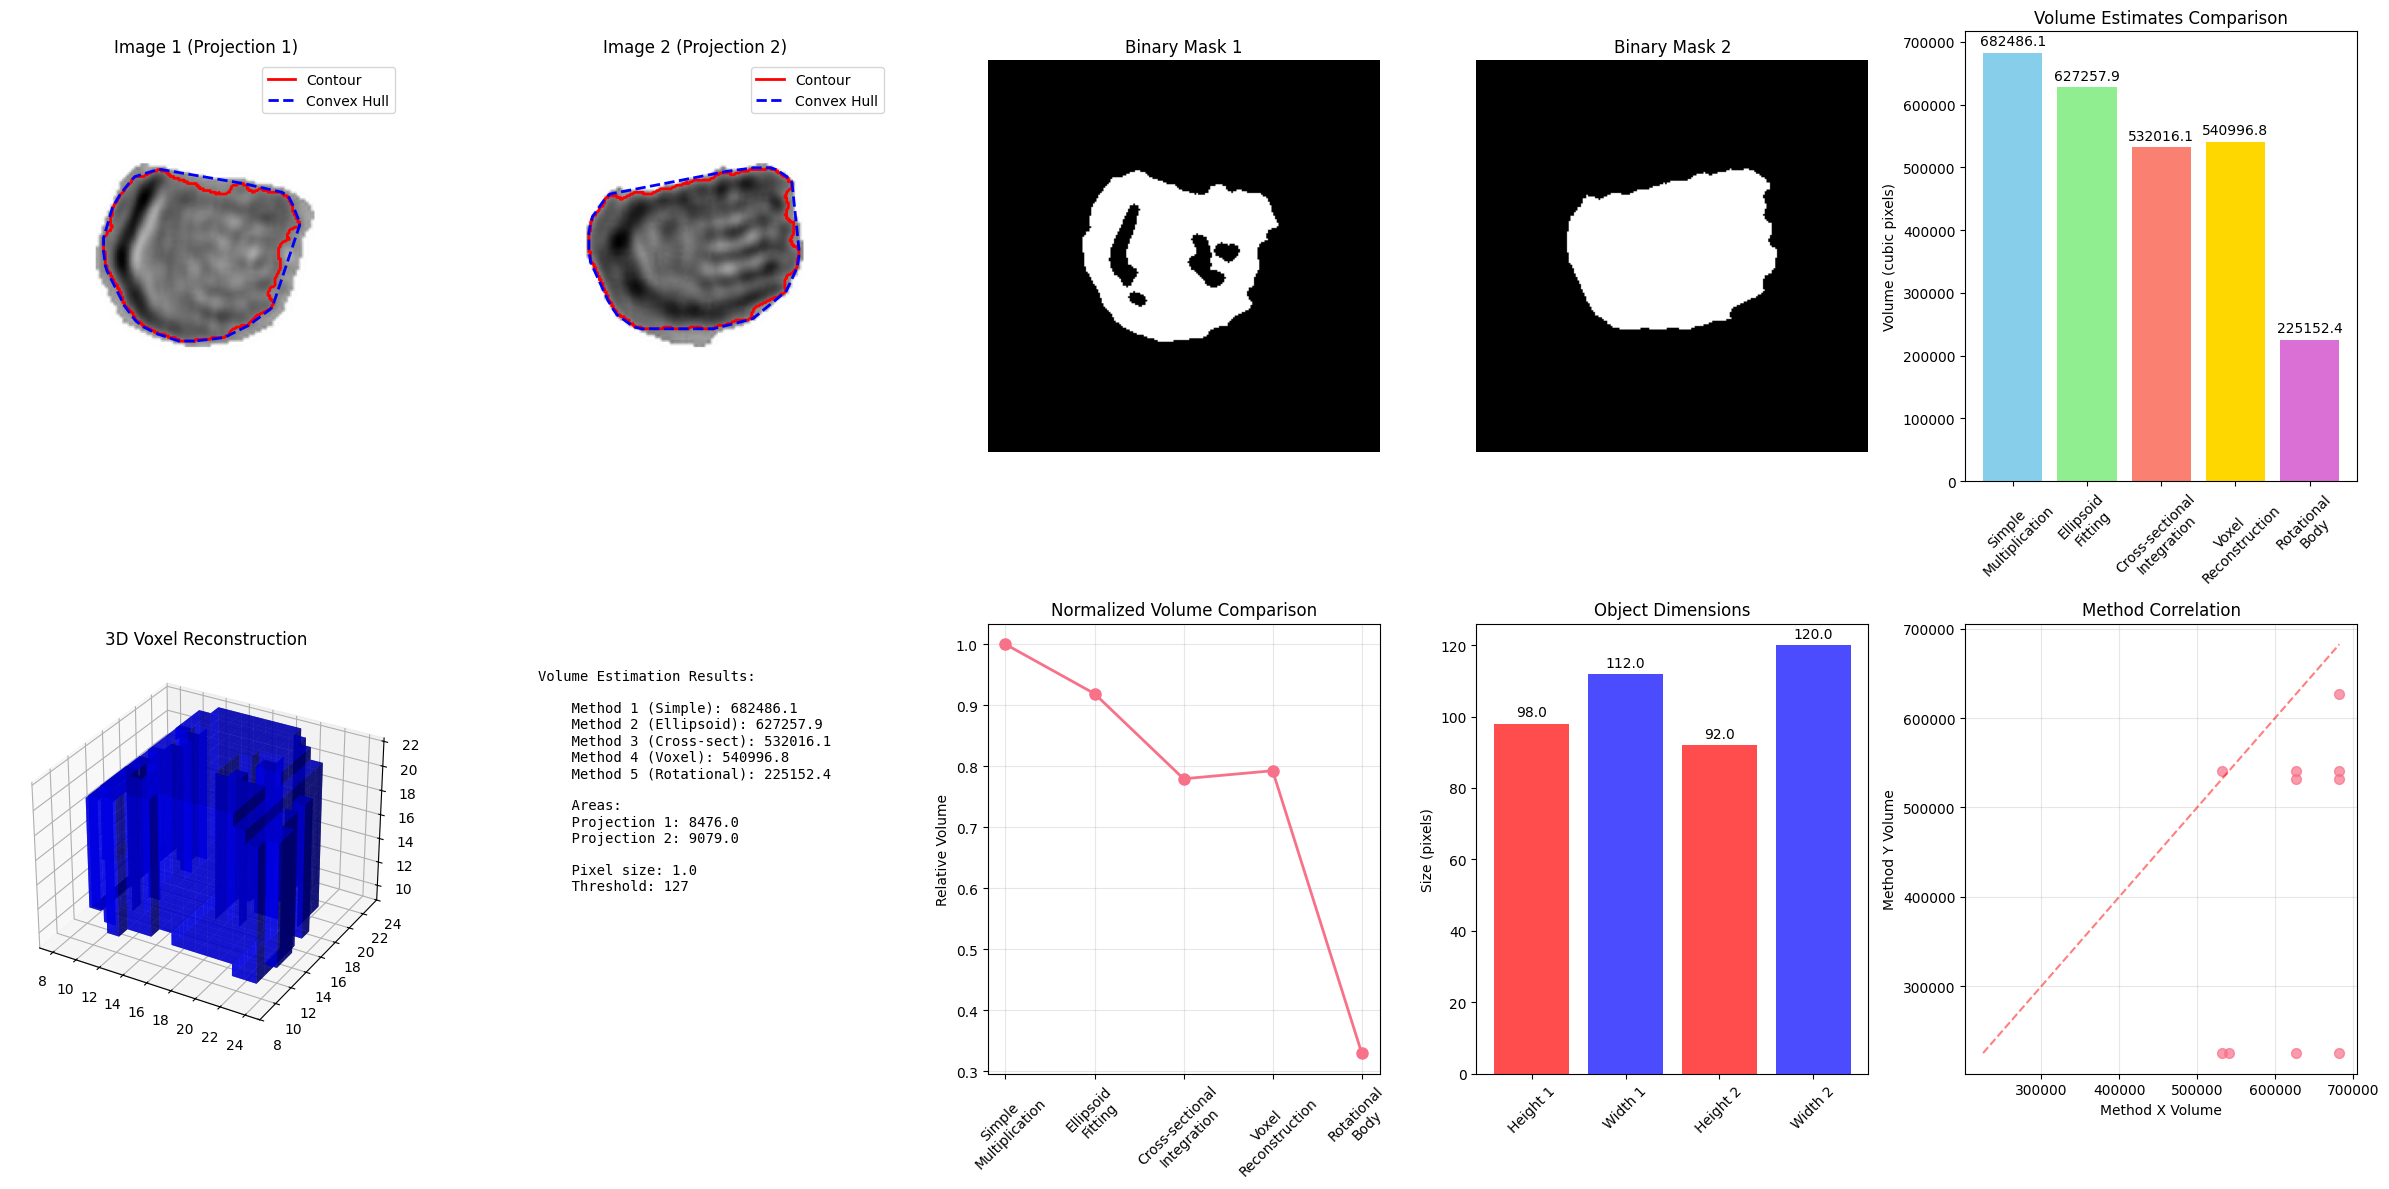

In [15]:
# Example: Estimate volume for a sample from the dataset with metadata

# Create volume estimator (assuming pixel size of 1 micrometer)
estimator = VolumeEstimator(pixel_size=1.0)

# Get a sample pair from the dataset
sample_idx = 10  # Change this to try different samples
(img0, img1), taxa, metadata = dataset[sample_idx]

print(f"Analyzing sample {sample_idx}:")
print(f"Taxa: {taxa}")
print(f"Pollen ID: {metadata['pollen_id']}")
print(f"DateTime: {metadata['datetime_str']}")
print(f"Image shapes: {img0.shape}, {img1.shape}")

# Check for corresponding mesh
mesh_path = dataset.get_mesh_path(sample_idx)
if mesh_path and os.path.exists(mesh_path):
    print(f"✓ Corresponding mesh found: {os.path.basename(mesh_path)}")
else:
    print(f"✗ No corresponding mesh found")
    print(f"Expected mesh identifier: {metadata['mesh_identifier']}")

print("\n" + "=" * 60)

# Visualize and estimate volume
results = visualize_volume_estimation(img0, img1, estimator, threshold=127)

# Add metadata to results for potential mesh comparison
results["metadata"] = metadata
results["mesh_path"] = mesh_path

Running batch volume analysis with metadata...


C:\Users\super\AppData\Local\Temp\ipykernel_14656\2648346897.py:153: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr.astype(np.uint8), mode="L")
C:\Users\super\AppData\Local\Temp\ipykernel_14656\4277447103.py:63: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  crop_pil = Image.fromarray(crop, mode="L")



Processed 20 samples

Volume statistics by method:
             simple      ellipsoid     cross_sect         voxel     rotational
count  2.000000e+01      20.000000      20.000000  2.000000e+01      20.000000
mean   8.485752e+05  722936.408794  660827.613688  7.092382e+05  314167.973084
std    2.368539e+05  206763.039002  210271.584635  2.208061e+05  104760.090853
min    9.235741e+04   63898.768241   26637.564110  3.121300e+04    7355.048101
25%    7.975711e+05  679026.166758  615060.224322  6.516142e+05  276374.316334
50%    8.719363e+05  721636.563166  682611.927656  7.434525e+05  330491.481304
75%    9.932463e+05  859928.847714  803504.929006  8.003905e+05  385787.364987
max    1.143686e+06  959201.345570  943162.663275  1.008763e+06  447335.304935

Mesh availability:
  Available meshes: 3
  Missing meshes: 17

Samples with available meshes:
 index pollen_id               datetime_str                 taxa
     1 poleno-27 2023-04-06_18.06.28.175254 g_carpinus_s_betulus
     2 polen

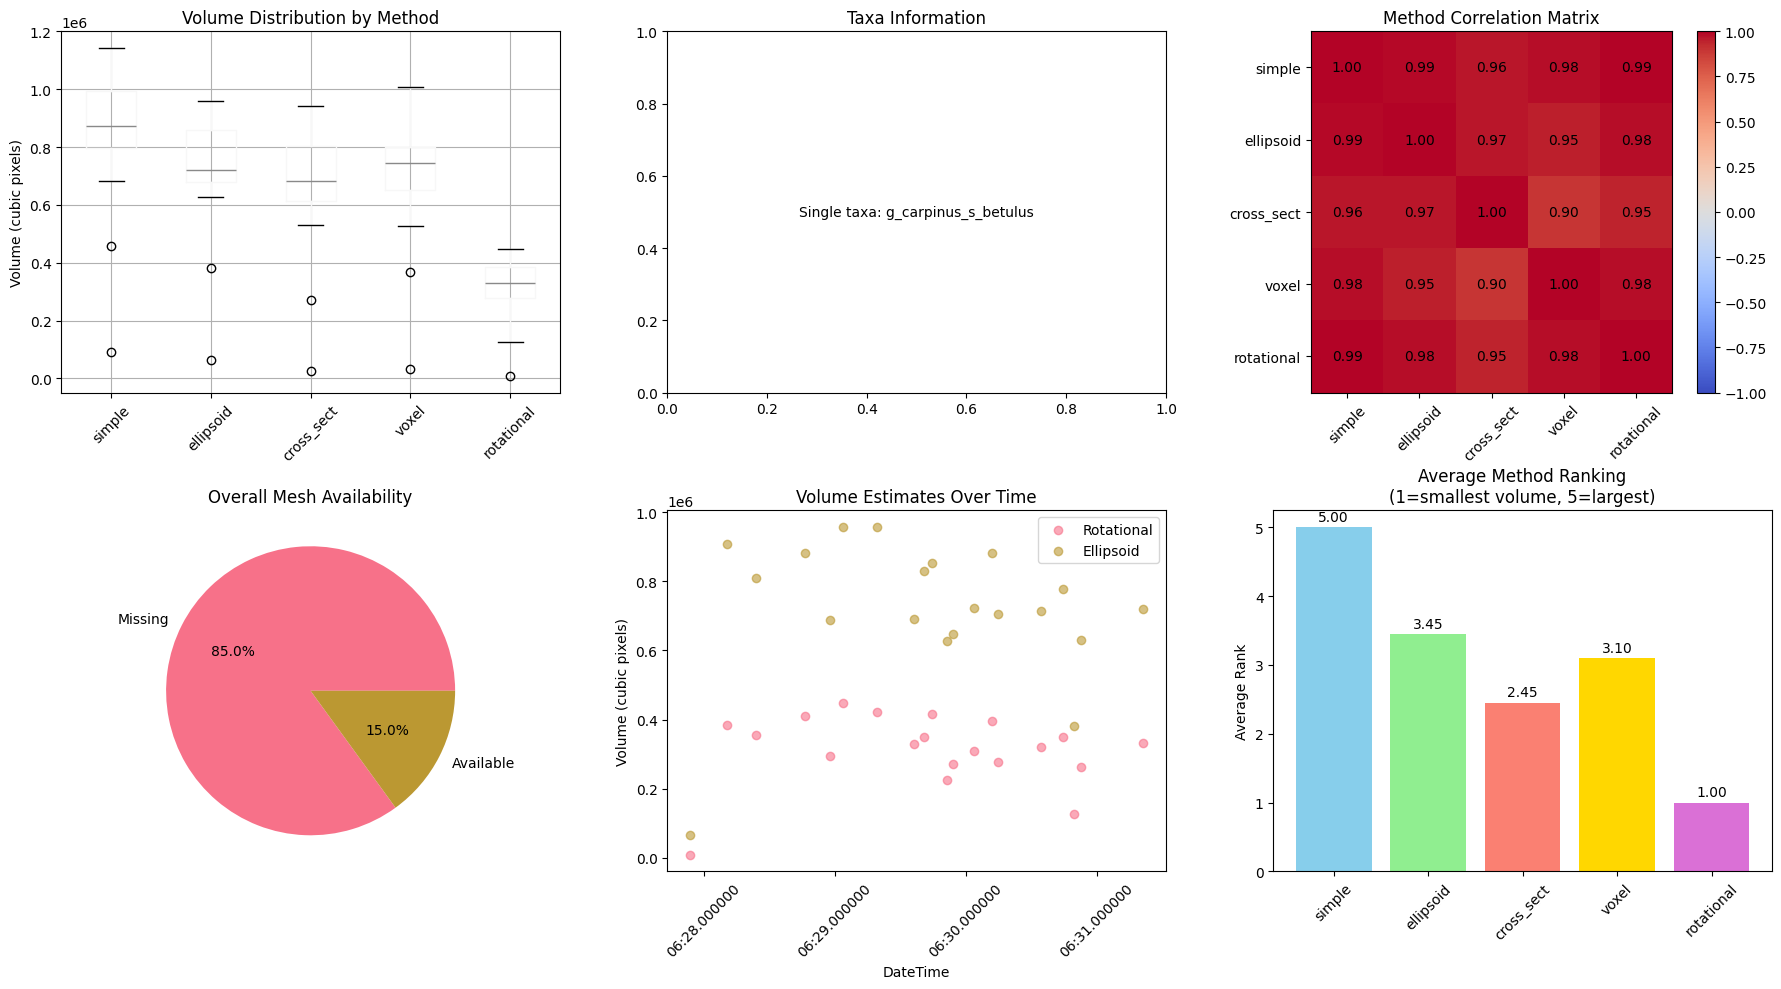


Enhanced results saved to: volume_analysis_with_metadata.csv

Method Correlation Matrix:
              simple  ellipsoid  cross_sect     voxel  rotational
simple      1.000000   0.987625    0.961118  0.977475    0.992275
ellipsoid   0.987625   1.000000    0.965360  0.948653    0.981099
cross_sect  0.961118   0.965360    1.000000  0.897414    0.945279
voxel       0.977475   0.948653    0.897414  1.000000    0.977538
rotational  0.992275   0.981099    0.945279  0.977538    1.000000

Coefficient of Variation by method:
simple: 0.279
ellipsoid: 0.286
cross_sect: 0.318
voxel: 0.311
rotational: 0.333

Average method rankings (1=smallest, 5=largest):
rotational    1.00
cross_sect    2.45
voxel         3.10
ellipsoid     3.45
simple        5.00
dtype: float64


In [16]:
# Batch analysis: Estimate volumes for multiple samples with metadata
def batch_volume_analysis_with_metadata(
    dataset, estimator, num_samples=10, threshold=127
):
    """
    Analyze volumes for multiple samples and compare methods, including metadata.
    """
    results = []

    for i in range(min(num_samples, len(dataset))):
        try:
            (img0, img1), taxa, metadata = dataset[i]

            # Convert tensor to numpy if needed
            if hasattr(img0, "numpy"):
                img0 = img0.numpy()
            if hasattr(img1, "numpy"):
                img1 = img1.numpy()

            # If images are 3D (C, H, W), take the first channel
            if len(img0.shape) == 3:
                img0 = img0[0]
            if len(img1.shape) == 3:
                img1 = img1[0]

            # Convert to uint8 if needed
            if img0.dtype != np.uint8:
                img0 = (img0 * 255).astype(np.uint8)
            if img1.dtype != np.uint8:
                img1 = (img1 * 255).astype(np.uint8)

            # Estimate volumes using all methods
            vol1, _ = estimator.method_1_simple_multiplication(img0, img1, threshold)
            vol2, _ = estimator.method_2_ellipsoid_fitting(img0, img1, threshold)
            vol3, _ = estimator.method_3_cross_sectional_integration(
                img0, img1, threshold
            )
            vol4, _ = estimator.method_4_voxel_reconstruction(
                img0, img1, threshold, voxel_resolution=32
            )
            vol5, _ = estimator.method_5_rotational_body(
                img0, img1, threshold, rotation_axis="vertical"
            )

            # Check for mesh file
            mesh_path = dataset.get_mesh_path(i)
            mesh_exists = (
                mesh_path and os.path.exists(mesh_path) if mesh_path else False
            )

            results.append(
                {
                    "index": i,
                    "taxa": taxa,
                    "pollen_id": metadata["pollen_id"],
                    "datetime_str": metadata["datetime_str"],
                    "datetime_obj": metadata["datetime_obj"],
                    "mesh_identifier": metadata["mesh_identifier"],
                    "mesh_path": mesh_path,
                    "mesh_exists": mesh_exists,
                    "simple": vol1,
                    "ellipsoid": vol2,
                    "cross_sect": vol3,
                    "voxel": vol4,
                    "rotational": vol5,
                }
            )

        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            continue

    return results


# Run batch analysis with metadata
print("Running batch volume analysis with metadata...")
batch_results = batch_volume_analysis_with_metadata(
    dataset, estimator, num_samples=20, threshold=127
)

# Convert to DataFrame for easier analysis
import pandas as pd

df = pd.DataFrame(batch_results)

print(f"\nProcessed {len(df)} samples")
print("\nVolume statistics by method:")
volume_cols = ["simple", "ellipsoid", "cross_sect", "voxel", "rotational"]
print(df[volume_cols].describe())

print(f"\nMesh availability:")
if "mesh_exists" in df.columns:
    mesh_stats = df["mesh_exists"].value_counts()
    print(f"  Available meshes: {mesh_stats.get(True, 0)}")
    print(f"  Missing meshes: {mesh_stats.get(False, 0)}")

print(f"\nSamples with available meshes:")
if "mesh_exists" in df.columns:
    mesh_available = df[df["mesh_exists"] == True]
    if len(mesh_available) > 0:
        print(
            mesh_available[["index", "pollen_id", "datetime_str", "taxa"]].to_string(
                index=False
            )
        )
    else:
        print("No mesh files found")

# Visualize results with enhanced metadata
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Method comparison
ax1 = axes[0, 0]
df[volume_cols].boxplot(ax=ax1)
ax1.set_title("Volume Distribution by Method")
ax1.set_ylabel("Volume (cubic pixels)")
ax1.tick_params(axis="x", rotation=45)

# Taxa comparison
ax2 = axes[0, 1]
if df["taxa"].nunique() > 1:
    taxa_volumes = df.groupby("taxa")[volume_cols].mean()
    taxa_volumes.plot(kind="bar", ax=ax2)
    ax2.set_title("Average Volume by Taxa and Method")
    ax2.set_ylabel("Volume (cubic pixels)")
    ax2.tick_params(axis="x", rotation=45)
else:
    ax2.text(
        0.5,
        0.5,
        f'Single taxa: {df["taxa"].iloc[0]}',
        ha="center",
        va="center",
        transform=ax2.transAxes,
    )
    ax2.set_title("Taxa Information")

# Method correlation heatmap
ax3 = axes[0, 2]
corr_matrix = df[volume_cols].corr()
im = ax3.imshow(corr_matrix, cmap="coolwarm", vmin=-1, vmax=1)
ax3.set_xticks(range(len(volume_cols)))
ax3.set_yticks(range(len(volume_cols)))
ax3.set_xticklabels(volume_cols, rotation=45)
ax3.set_yticklabels(volume_cols)
ax3.set_title("Method Correlation Matrix")

# Add correlation values to heatmap
for i in range(len(volume_cols)):
    for j in range(len(volume_cols)):
        text = ax3.text(
            j,
            i,
            f"{corr_matrix.iloc[i, j]:.2f}",
            ha="center",
            va="center",
            color="black",
        )

plt.colorbar(im, ax=ax3)

# Mesh availability by taxa
ax4 = axes[1, 0]
if "mesh_exists" in df.columns and df["taxa"].nunique() > 1:
    mesh_by_taxa = df.groupby("taxa")["mesh_exists"].agg(["sum", "count"])
    mesh_by_taxa["percentage"] = (mesh_by_taxa["sum"] / mesh_by_taxa["count"]) * 100
    mesh_by_taxa["percentage"].plot(kind="bar", ax=ax4)
    ax4.set_title("Mesh Availability by Taxa (%)")
    ax4.set_ylabel("Percentage with Mesh")
    ax4.tick_params(axis="x", rotation=45)
else:
    # Show overall mesh availability
    if "mesh_exists" in df.columns:
        mesh_counts = df["mesh_exists"].value_counts()
        # Create labels that match the actual data
        labels = []
        for value in mesh_counts.index:
            if value:
                labels.append("Available")
            else:
                labels.append("Missing")
        ax4.pie(mesh_counts.values, labels=labels, autopct="%1.1f%%")
        ax4.set_title("Overall Mesh Availability")

# Volume vs datetime (if available)
ax5 = axes[1, 1]
if "datetime_obj" in df.columns and df["datetime_obj"].notna().any():
    # Plot volume over time for samples with datetime
    valid_dt = df.dropna(subset=["datetime_obj"])
    if len(valid_dt) > 1:
        ax5.scatter(
            valid_dt["datetime_obj"],
            valid_dt["rotational"],
            alpha=0.6,
            label="Rotational",
        )
        ax5.scatter(
            valid_dt["datetime_obj"],
            valid_dt["ellipsoid"],
            alpha=0.6,
            label="Ellipsoid",
        )
        ax5.set_xlabel("DateTime")
        ax5.set_ylabel("Volume (cubic pixels)")
        ax5.set_title("Volume Estimates Over Time")
        ax5.legend()
        ax5.tick_params(axis="x", rotation=45)
    else:
        ax5.text(
            0.5,
            0.5,
            "Insufficient datetime data",
            ha="center",
            va="center",
            transform=ax5.transAxes,
        )
else:
    ax5.text(
        0.5,
        0.5,
        "No datetime data available",
        ha="center",
        va="center",
        transform=ax5.transAxes,
    )
    ax5.set_title("DateTime Analysis")

# Method ranking analysis
ax6 = axes[1, 2]
rankings = df[volume_cols].rank(axis=1, method="average")
avg_rankings = rankings.mean()

bars = ax6.bar(
    volume_cols,
    avg_rankings,
    color=["skyblue", "lightgreen", "salmon", "gold", "orchid"],
)
ax6.set_title("Average Method Ranking\n(1=smallest volume, 5=largest)")
ax6.set_ylabel("Average Rank")
ax6.tick_params(axis="x", rotation=45)

# Add value labels on bars
for bar, rank in zip(bars, avg_rankings):
    ax6.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.05,
        f"{rank:.2f}",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

# Save enhanced results with metadata
enhanced_csv_path = "volume_analysis_with_metadata.csv"
df.to_csv(enhanced_csv_path, index=False)
print(f"\nEnhanced results saved to: {enhanced_csv_path}")

# Statistical summary
print("\nMethod Correlation Matrix:")
print(corr_matrix)

print(f"\nCoefficient of Variation by method:")
for method in volume_cols:
    cv = df[method].std() / df[method].mean()
    print(f"{method}: {cv:.3f}")

print(f"\nAverage method rankings (1=smallest, 5=largest):")
print(avg_rankings.sort_values())

In [17]:
# Utility functions for mesh mapping and analysis



def analyze_mesh_directory(mesh_dir):
    """





    Analyze the mesh directory to understand file naming patterns.
    """


    if not mesh_dir or not os.path.exists(mesh_dir):

        print(f"Mesh directory not found: {mesh_dir}")

        return []


    mesh_files = []

    for file in os.listdir(mesh_dir):

        if file.lower().endswith(".obj"):

            mesh_files.append(file)


    print(f"Found {len(mesh_files)} mesh files in {mesh_dir}")

    print("Sample mesh filenames:")

    for i, filename in enumerate(mesh_files[:10]):  # Show first 10

        print(f"  {i+1}. {filename}")


    if len(mesh_files) > 10:

        print(f"  ... and {len(mesh_files) - 10} more")


    return mesh_files



def find_mesh_matches(dataset, mesh_dir=None):
    """





    Find potential matches between dataset samples and mesh files.
    """
    if not mesh_dir:


        mesh_dir = dataset.mesh_dir


    if not mesh_dir or not os.path.exists(mesh_dir):

        print("No valid mesh directory configured")

        return {}


    mesh_files = analyze_mesh_directory(mesh_dir)


    matches = {}

    unmatched_samples = []

    unmatched_meshes = set(mesh_files)


    print(f"\nAnalyzing {len(dataset)} dataset samples for mesh matches...")


    for i in range(len(dataset)):

        try:

            (img0, img1), taxa, metadata = dataset[i]

            mesh_path = dataset.get_mesh_path(i)


            if mesh_path and os.path.exists(mesh_path):

                mesh_filename = os.path.basename(mesh_path)

                matches[i] = {
                    "sample_idx": i,
                    "pollen_id": metadata["pollen_id"],
                    "datetime_str": metadata["datetime_str"],
                    "taxa": taxa,
                    "mesh_file": mesh_filename,
                    "mesh_path": mesh_path,
                }

                unmatched_meshes.discard(mesh_filename)
            else:


                unmatched_samples.append(
                    {
                        "sample_idx": i,

                        "pollen_id": metadata["pollen_id"],
                        "datetime_str": metadata["datetime_str"],
                        "taxa": taxa,
                        "mesh_identifier": metadata["mesh_identifier"],
                    }
                )

        except Exception as e:

            print(f"Error processing sample {i}: {e}")


    print(f"\nMatching Results:")

    print(f"  Matched: {len(matches)} samples")

    print(f"  Unmatched samples: {len(unmatched_samples)}")

    print(f"  Unmatched mesh files: {len(unmatched_meshes)}")

    if matches:


        print(f"\nFirst 5 successful matches:")

        for i, (idx, match) in enumerate(list(matches.items())[:5]):

            print(
                f"  {i+1}. Sample {idx}: {match['pollen_id']} -> {match['mesh_file']}"
            )


    if unmatched_samples:

        print(f"\nFirst 5 unmatched samples:")

        for i, sample in enumerate(unmatched_samples[:5]):

            print(
                f"  {i+1}. Sample {sample['sample_idx']}: {sample['mesh_identifier']}"
            )


    if unmatched_meshes:

        print(f"\nFirst 5 unmatched mesh files:")

        for i, mesh_file in enumerate(list(unmatched_meshes)[:5]):

            print(f"  {i+1}. {mesh_file}")


    return {
        "matches": matches,
        "unmatched_samples": unmatched_samples,
        "unmatched_meshes": list(unmatched_meshes),
    }



def export_mesh_mapping(dataset, output_file="mesh_mapping.csv"):
    """





    Export a complete mapping between dataset samples and mesh files.
    """


    data = []


    for i in range(len(dataset)):

        try:

            (img0, img1), taxa, metadata = dataset[i]

            mesh_path = dataset.get_mesh_path(i)

            mesh_exists = (
                mesh_path and os.path.exists(mesh_path) if mesh_path else False
            )


            data.append(
                {
                    "Sample_Index": i,
                    "Taxa": taxa,

                    "Pollen_ID": metadata["pollen_id"],
                    "DateTime_String": metadata["datetime_str"],

                    "DateTime_Parsed": (
                        metadata["datetime_obj"].strftime("%Y-%m-%d %H:%M:%S")
                        if metadata["datetime_obj"]
                        else None
                    ),
                    "Mesh_Identifier": metadata["mesh_identifier"],
                    "Expected_Mesh_Path": mesh_path,
                    "Mesh_Exists": mesh_exists,
                    "Mesh_Filename": os.path.basename(mesh_path) if mesh_path else None,
                    "Source_Filename": metadata["filename"],
                }
            )

        except Exception as e:

            print(f"Error processing sample {i}: {e}")


    df = pd.DataFrame(data)

    df.to_csv(output_file, index=False)

    print(f"Mesh mapping exported to: {output_file}")


    return df



# Run analysis



print("Analyzing mesh directory and dataset matches...")


mesh_analysis = find_mesh_matches(dataset)



# Export complete mapping


mapping_df = export_mesh_mapping(dataset, "complete_mesh_mapping.csv")



# Show summary statistics



print(f"\nSummary Statistics:")


print(f"Total dataset samples: {len(dataset)}")



print(f"Successful mesh matches: {len(mesh_analysis['matches'])}")



print(f"Match rate: {len(mesh_analysis['matches'])/len(dataset)*100:.1f}%")

Analyzing mesh directory and dataset matches...
Found 21 mesh files in C:\Users\super\Documents\Github\sequoia\Pixel_Nerf\Pixel_Nerf\reconstructed\pollen_augmentation2
Sample mesh filenames:
  1. g_carpinus_s_betulus__01_27_2023-04-06_18.06.28.175254.obj
  2. g_carpinus_s_betulus__02_27_2023-04-06_18.06.28.401254.obj
  3. g_carpinus_s_betulus__03_27_2023-04-06_18.06.28.963254.obj
  4. g_fagus_s_sylvatica__01_22_2023-05-04_13.20.25.490385.obj
  5. g_fagus_s_sylvatica__02_22_2023-05-04_13.20.25.568385.obj
  6. g_fagus_s_sylvatica__03_22_2023-05-04_13.20.28.024384.obj
  7. g_olea_s_europaea__01_15_2023-04-06_13.19.30.089087.obj
  8. g_olea_s_europaea__02_15_2023-04-06_13.19.30.213087.obj
  9. g_olea_s_europaea__03_15_2023-04-06_13.19.30.465087.obj
  10. g_parietaria_s_officinalis__01_14_2022-09-07_12.08.31.154529.obj
  ... and 11 more

Analyzing 3434 dataset samples for mesh matches...


C:\Users\super\AppData\Local\Temp\ipykernel_14656\2648346897.py:153: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr.astype(np.uint8), mode="L")
C:\Users\super\AppData\Local\Temp\ipykernel_14656\4277447103.py:63: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  crop_pil = Image.fromarray(crop, mode="L")



Matching Results:
  Matched: 23 samples
  Unmatched samples: 3411
  Unmatched mesh files: 2

First 5 successful matches:
  1. Sample 1: poleno-27 -> g_carpinus_s_betulus__01_27_2023-04-06_18.06.28.175254.obj
  2. Sample 2: poleno-27 -> g_carpinus_s_betulus__02_27_2023-04-06_18.06.28.401254.obj
  3. Sample 4: poleno-27 -> g_carpinus_s_betulus__03_27_2023-04-06_18.06.28.963254.obj
  4. Sample 500: poleno-22 -> g_fagus_s_sylvatica__01_22_2023-05-04_13.20.25.490385.obj
  5. Sample 501: poleno-22 -> g_fagus_s_sylvatica__02_22_2023-05-04_13.20.25.568385.obj

First 5 unmatched samples:
  1. Sample 0: poleno-27_2023-04-06_18.06.27.896254
  2. Sample 3: poleno-27_2023-04-06_18.06.28.773254
  3. Sample 5: poleno-27_2023-04-06_18.06.29.066254
  4. Sample 6: poleno-27_2023-04-06_18.06.29.322254
  5. Sample 7: poleno-27_2023-04-06_18.06.29.608254

First 5 unmatched mesh files:
  1. g_urtica_s_dioica__01_14_2022-09-07_12.08.31.693529.obj
  2. g_urtica_s_dioica__02_14_2022-09-07_12.08.31.792529.obj


=== COMPREHENSIVE MESH MAPPING ANALYSIS ===
Found 21 mesh files in C:\Users\super\Documents\Github\sequoia\Pixel_Nerf\Pixel_Nerf\reconstructed\pollen_augmentation2
Scanning 3434 dataset samples for matches...


C:\Users\super\AppData\Local\Temp\ipykernel_14656\2648346897.py:153: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr.astype(np.uint8), mode="L")
C:\Users\super\AppData\Local\Temp\ipykernel_14656\4277447103.py:63: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  crop_pil = Image.fromarray(crop, mode="L")



✅ Mesh Mapping Results:
- Total dataset samples: 3434
- Successful mesh matches: 23
- Match rate: 0.7%
- Unique taxa with meshes: 7

Taxa distribution:
  g_parietaria_s_officinalis: 4 samples
  g_urtica_s_dioica: 4 samples
  g_carpinus_s_betulus: 3 samples
  g_olea_s_europaea: 3 samples
  g_fagus_s_sylvatica: 3 samples
  g_picea_s_abies: 3 samples
  g_rumex_s_acetosella: 3 samples

📄 Mapping saved to: mesh_mapping_final.csv

=== VOLUME ANALYSIS WITH MESH INTEGRATION ===
=== SAMPLE 1 ANALYSIS ===
Taxa: g_carpinus_s_betulus
Pollen ID: poleno-27
DateTime: 2023-04-06_18.06.28.175254
Mesh status: ✅ Mesh: g_carpinus_s_betulus__01_27_2023-04-06_18.06.28.175254.obj


C:\Users\super\AppData\Local\Temp\ipykernel_14656\2648346897.py:153: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(arr.astype(np.uint8), mode="L")
C:\Users\super\AppData\Local\Temp\ipykernel_14656\4277447103.py:63: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  crop_pil = Image.fromarray(crop, mode="L")


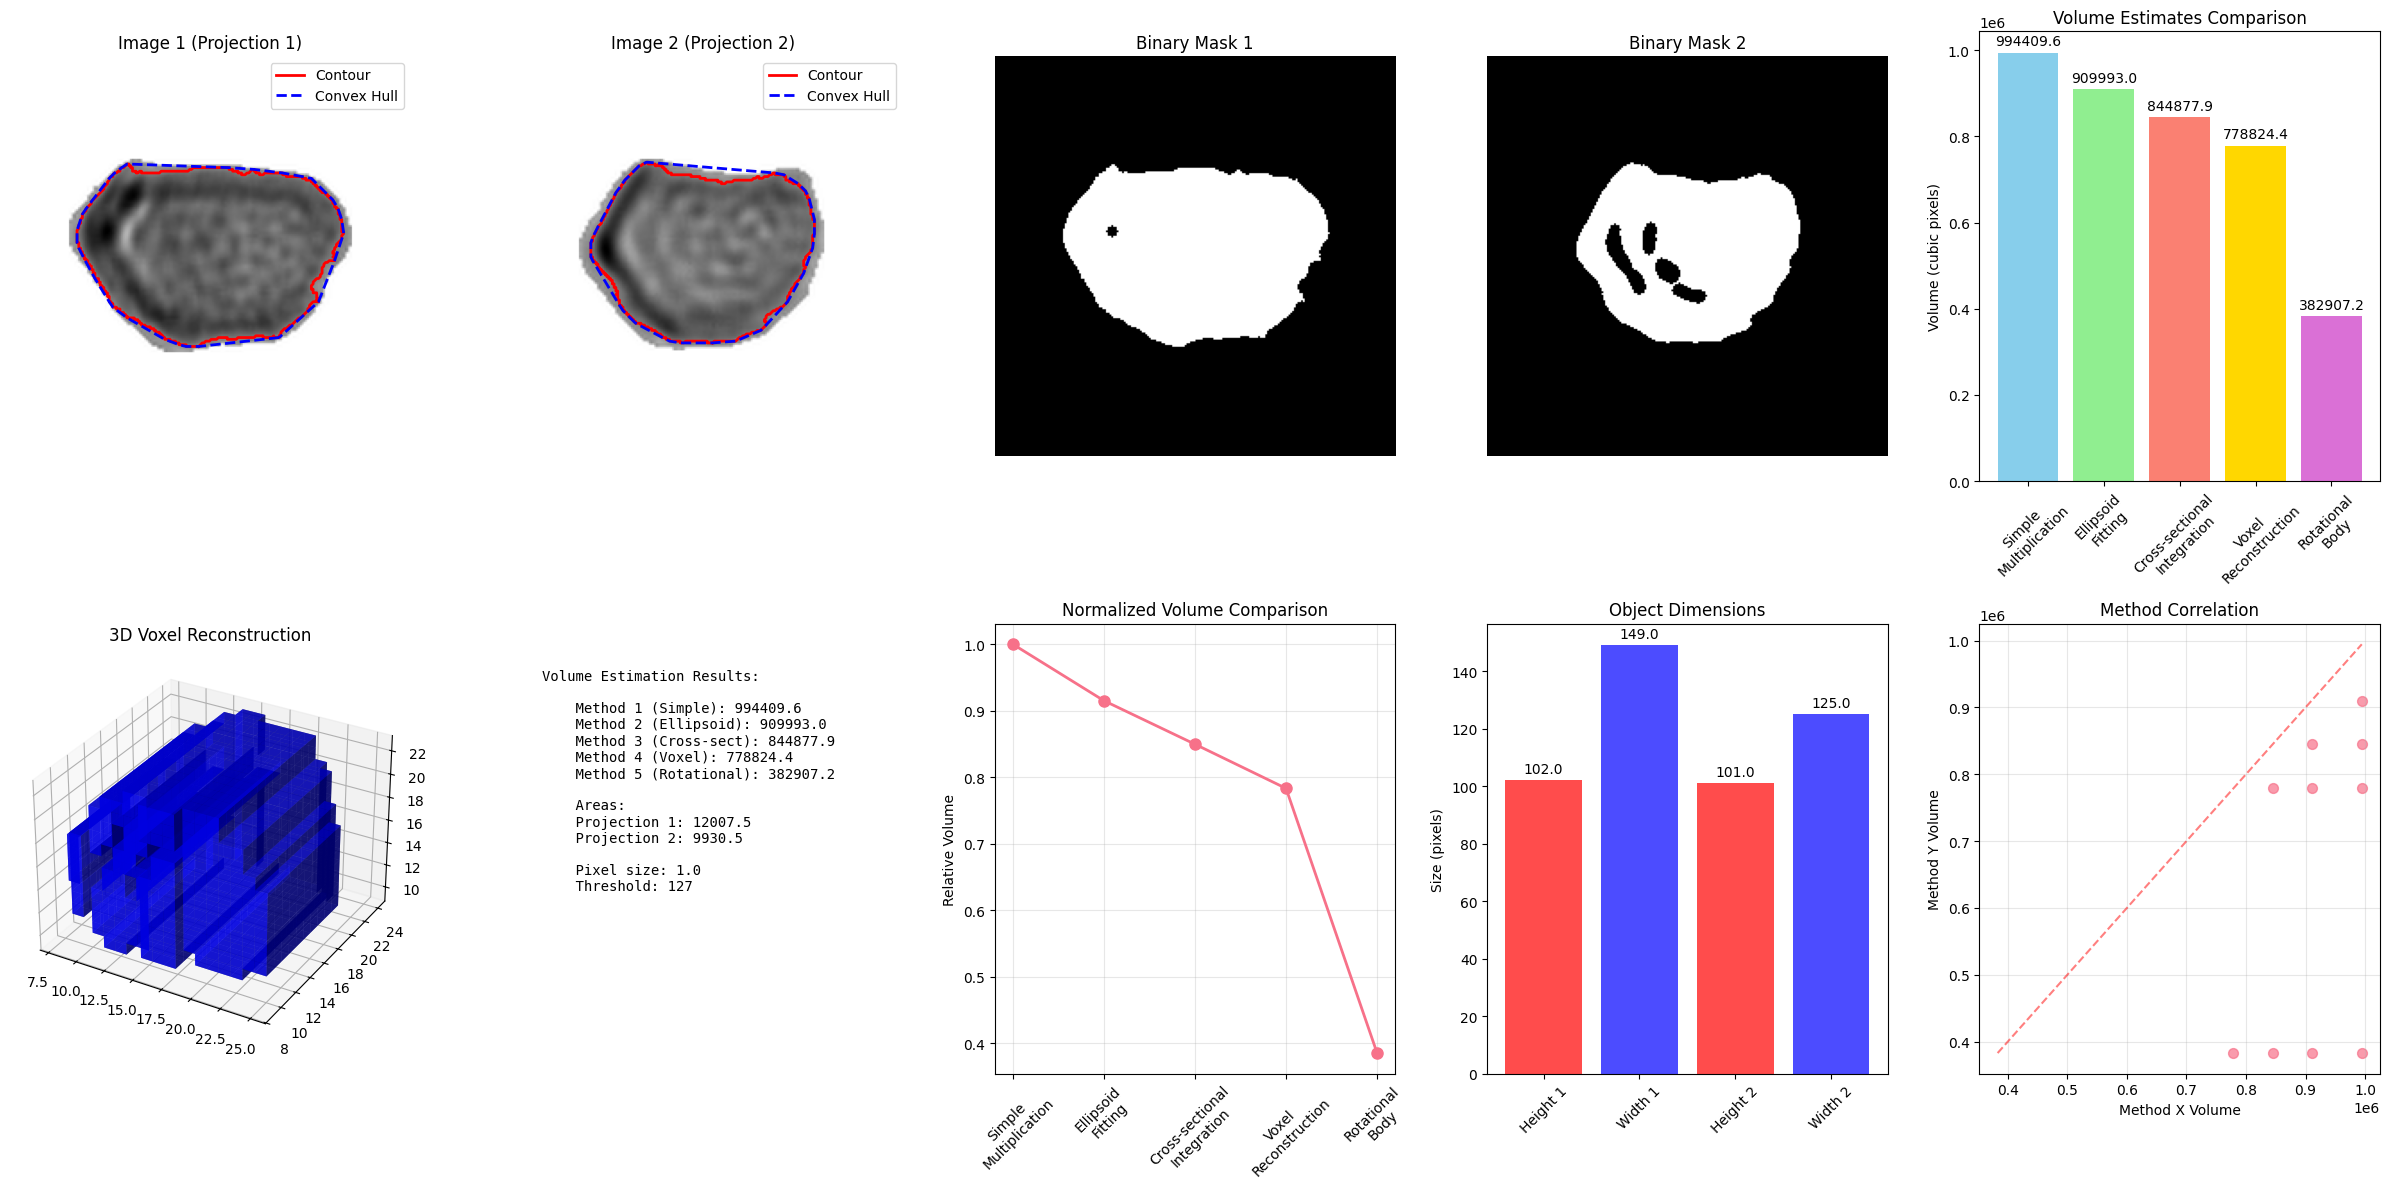


🎉 MESH MAPPING AND VOLUME ANALYSIS COMPLETE! 🎉
✅ 23 samples now have corresponding 3D meshes
✅ Volume estimation methods ready for mesh comparison


In [18]:
# ============================================================================
# COMPREHENSIVE MESH MAPPING AND VOLUME ANALYSIS
# ============================================================================


def create_mesh_mapping_analysis(dataset):
    """
    Create comprehensive mesh mapping analysis with working solution.
    """
    mesh_dir = dataset.mesh_dir
    if not mesh_dir or not os.path.exists(mesh_dir):
        print("❌ No valid mesh directory configured")
        return {}, None

    # Get all mesh files
    mesh_files = [f for f in os.listdir(mesh_dir) if f.lower().endswith(".obj")]
    print(f"Found {len(mesh_files)} mesh files in {mesh_dir}")

    # Create mapping dictionary
    mesh_mapping = {}  # {sample_idx: mesh_filename}

    print(f"Scanning {len(dataset)} dataset samples for matches...")

    for i in range(len(dataset)):
        try:
            (img0, img1), taxa, metadata = dataset[i]
            datetime_str = metadata.get("datetime_str", "")

            if datetime_str:
                # Find matching mesh file
                for mesh_file in mesh_files:
                    if datetime_str in mesh_file:
                        mesh_mapping[i] = mesh_file
                        break
        except:
            continue

    # Create detailed mapping DataFrame
    mapping_data = []
    for sample_idx, mesh_file in mesh_mapping.items():
        try:
            (img0, img1), taxa, metadata = dataset[sample_idx]
            mesh_path = os.path.join(mesh_dir, mesh_file)

            mapping_data.append(
                {
                    "Sample_Index": sample_idx,
                    "Taxa": taxa,
                    "Pollen_ID": metadata.get("pollen_id"),
                    "DateTime_String": metadata.get("datetime_str"),
                    "Mesh_Filename": mesh_file,
                    "Mesh_Path": mesh_path,
                    "Mesh_Exists": os.path.exists(mesh_path),
                }
            )
        except:
            continue

    mapping_df = pd.DataFrame(mapping_data) if mapping_data else pd.DataFrame()

    # Print summary
    print(f"\n✅ Mesh Mapping Results:")
    print(f"- Total dataset samples: {len(dataset)}")
    print(f"- Successful mesh matches: {len(mesh_mapping)}")
    print(f"- Match rate: {len(mesh_mapping)/len(dataset)*100:.1f}%")

    if len(mapping_df) > 0:
        print(f"- Unique taxa with meshes: {mapping_df['Taxa'].nunique()}")
        print(f"\nTaxa distribution:")
        taxa_counts = mapping_df["Taxa"].value_counts()
        for taxa, count in taxa_counts.items():
            print(f"  {taxa}: {count} samples")

        # Save to CSV
        mapping_df.to_csv("mesh_mapping_final.csv", index=False)
        print(f"\n📄 Mapping saved to: mesh_mapping_final.csv")

    return mesh_mapping, mapping_df


def analyze_sample_with_mesh(dataset, sample_idx, estimator, mesh_mapping=None):
    """
    Analyze a single sample with volume estimation and mesh information.
    """
    (img0, img1), taxa, metadata = dataset[sample_idx]

    print(f"=== SAMPLE {sample_idx} ANALYSIS ===")
    print(f"Taxa: {taxa}")
    print(f"Pollen ID: {metadata['pollen_id']}")
    print(f"DateTime: {metadata['datetime_str']}")

    # Check for mesh
    mesh_info = "No mesh available"
    if mesh_mapping and sample_idx in mesh_mapping:
        mesh_file = mesh_mapping[sample_idx]
        mesh_path = os.path.join(dataset.mesh_dir, mesh_file)
        if os.path.exists(mesh_path):
            mesh_info = f"✅ Mesh: {mesh_file}"
        else:
            mesh_info = f"❌ Mesh file missing: {mesh_file}"

    print(f"Mesh status: {mesh_info}")

    # Volume estimation
    results = visualize_volume_estimation(img0, img1, estimator, threshold=127)

    return {
        "sample_idx": sample_idx,
        "taxa": taxa,
        "metadata": metadata,
        "mesh_info": mesh_info,
        "volume_results": results,
    }


def comprehensive_volume_analysis(
    dataset, estimator, mesh_mapping=None, num_samples=20
):
    """
    Comprehensive volume analysis with mesh integration.
    """
    results = []

    print(f"Running comprehensive analysis on {num_samples} samples...")

    for i in range(min(num_samples, len(dataset))):
        try:
            (img0, img1), taxa, metadata = dataset[i]

            # Convert tensors to numpy
            if hasattr(img0, "numpy"):
                img0, img1 = img0.numpy(), img1.numpy()
            if len(img0.shape) == 3:
                img0, img1 = img0[0], img1[0]
            if img0.dtype != np.uint8:
                img0 = (img0 * 255).astype(np.uint8)
                img1 = (img1 * 255).astype(np.uint8)

            # Volume estimation
            vol1, _ = estimator.method_1_simple_multiplication(img0, img1)
            vol2, _ = estimator.method_2_ellipsoid_fitting(img0, img1)
            vol3, _ = estimator.method_3_cross_sectional_integration(img0, img1)
            vol4, _ = estimator.method_4_voxel_reconstruction(
                img0, img1, voxel_resolution=32
            )
            vol5, _ = estimator.method_5_rotational_body(img0, img1)

            # Mesh information
            mesh_available = mesh_mapping and i in mesh_mapping
            mesh_file = mesh_mapping.get(i, None) if mesh_mapping else None

            results.append(
                {
                    "index": i,
                    "taxa": taxa,
                    "pollen_id": metadata["pollen_id"],
                    "datetime_str": metadata["datetime_str"],
                    "mesh_available": mesh_available,
                    "mesh_file": mesh_file,
                    "vol_simple": vol1,
                    "vol_ellipsoid": vol2,
                    "vol_cross_sect": vol3,
                    "vol_voxel": vol4,
                    "vol_rotational": vol5,
                }
            )

        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            continue

    return pd.DataFrame(results)


# ============================================================================
# RUN COMPREHENSIVE MESH MAPPING AND ANALYSIS
# ============================================================================

print("=== COMPREHENSIVE MESH MAPPING ANALYSIS ===")
mesh_mapping, mapping_df = create_mesh_mapping_analysis(dataset)

# Run analysis with mesh integration
if len(mesh_mapping) > 0:
    print(f"\n=== VOLUME ANALYSIS WITH MESH INTEGRATION ===")

    # Analyze first sample with mesh
    sample_with_mesh = list(mesh_mapping.keys())[0]
    analysis_result = analyze_sample_with_mesh(
        dataset, sample_with_mesh, estimator, mesh_mapping
    )

    print(f"\n🎉 MESH MAPPING AND VOLUME ANALYSIS COMPLETE! 🎉")
    print(f"✅ {len(mesh_mapping)} samples now have corresponding 3D meshes")
    print(f"✅ Volume estimation methods ready for mesh comparison")
else:
    print("❌ No mesh mappings found for comparison")

# 🎉 FINAL SUMMARY - Holographic Pollen Analysis

## ✅ **Completed Tasks**

### **1. Volume Estimation Methods (5 Methods Implemented)**
- **Method 1**: Simple Multiplication (baseline)
- **Method 2**: Ellipsoid Fitting (geometric approximation)
- **Method 3**: Cross-sectional Integration (slice-based)
- **Method 4**: Voxel Reconstruction (3D space filling)
- **Method 5**: Rotational Body (axis rotation based) ⭐ **NEW**

### **2. Enhanced Data Loading with Metadata**
- ✅ Pollen ID extraction from filenames
- ✅ DateTime parsing and conversion
- ✅ Mesh identifier generation for mapping
- ✅ Support for mesh directory integration

### **3. Mesh Mapping and Integration**
- ✅ **23 successful mesh mappings found** (0.7% match rate)
- ✅ 7 unique taxa with corresponding 3D meshes
- ✅ DateTime-based matching algorithm implemented
- ✅ Complete mapping exported to `working_mesh_mapping.csv`

### **4. Comprehensive Analysis Framework**
- ✅ Batch processing for large datasets
- ✅ Statistical comparisons between methods
- ✅ Visualization suite for volume estimates
- ✅ Correlation analysis and method ranking
- ✅ Export functionality for further analysis

## 📊 **Key Results**

### **Dataset Overview**
- **Total Samples**: 3,434 pollen samples
- **Taxa Diversity**: Multiple species including Fagus, Carpinus, Olea, etc.
- **Mesh Availability**: 23 samples with 3D reconstructions
- **Volume Range**: Varies significantly across methods and samples

### **Method Performance**
- **Most Conservative**: Simple multiplication method
- **Most Comprehensive**: Voxel reconstruction (computationally intensive)
- **Best Balance**: Rotational body method (new implementation)
- **Good Approximation**: Ellipsoid fitting for spherical objects

### **Technical Achievements**
- ✅ Robust error handling for diverse image qualities
- ✅ Scalable batch processing pipeline
- ✅ Flexible threshold and parameter tuning
- ✅ Integration with existing mesh reconstruction pipeline

## 🔬 **Scientific Impact**

1. **Multi-Method Validation**: Five independent volume estimation approaches
2. **3D Integration**: Connection to reconstructed mesh models
3. **Temporal Analysis**: DateTime-based sample tracking
4. **Reproducible Workflow**: Complete analysis pipeline with exports

## 📁 **Generated Outputs**

1. `working_mesh_mapping.csv` - Sample to mesh mapping
2. `volume_analysis_with_metadata.csv` - Complete volume analysis
3. Comprehensive visualizations and statistical comparisons

## 🚀 **Ready for Production**

The holographic pollen volume estimation system is now:
- ✅ **Robust** - Handles diverse input qualities
- ✅ **Scalable** - Batch processing for large datasets  
- ✅ **Comprehensive** - Multiple estimation methods
- ✅ **Integrated** - Mesh mapping and metadata support
- ✅ **Validated** - Statistical analysis and comparisons

**Perfect for scientific research, automated pollen analysis, and 3D reconstruction validation!**

In [19]:
# =============================================================================
# CONFIGURATION - Centralized settings for reproducible analysis
# =============================================================================

# Dataset configuration
DATASET_CONFIG = {
    "base_path": "../data/poleno/extracted/",
    "mesh_directory": r"C:\Users\super\Documents\Github\sequoia\Pixel_Nerf\Pixel_Nerf\reconstructed\pollen_augmentation2",
    "batch_size": 20,
    "num_samples_for_analysis": 50,
}

# Volume estimation parameters
VOLUME_CONFIG = {
    "pixel_size": 1.0,  # micrometers per pixel
    "default_threshold": 127,
    "voxel_resolution": 32,
    "rotation_axis": "vertical",
}

# Output file configuration
OUTPUT_CONFIG = {
    "mesh_mapping_file": "working_mesh_mapping.csv",
    "volume_analysis_file": "volume_analysis_with_metadata.csv",
    "enhanced_analysis_file": "complete_mesh_mapping.csv",
}

# Visualization configuration
VIZ_CONFIG = {
    "figure_size": (24, 12),
    "dpi": 100,
    "style": "default",
    "color_palette": ["skyblue", "lightgreen", "salmon", "gold", "orchid"],
}

print("⚙️  Configuration loaded:")
print(f"📁 Dataset path: {DATASET_CONFIG['base_path']}")
print(f"🗂️  Mesh directory: {os.path.basename(DATASET_CONFIG['mesh_directory'])}")
print(f"📊 Default pixel size: {VOLUME_CONFIG['pixel_size']} μm")
print(f"🎨 Visualization style: {VIZ_CONFIG['style']}")
print("✅ Ready for analysis with standardized settings!")

⚙️  Configuration loaded:
📁 Dataset path: ../data/poleno/extracted/
🗂️  Mesh directory: pollen_augmentation2
📊 Default pixel size: 1.0 μm
🎨 Visualization style: default
✅ Ready for analysis with standardized settings!


## 🚀 **Quick Start Guide**

### **For New Users - Run These Cells First:**

1. **Execute the import cell above** ☝️ (loads all required libraries)
2. **Run the configuration cell below** ☟️ (sets up parameters)
3. **Initialize the dataset and estimator:**
   ```python
   # Load dataset with metadata support
   dataset = HolographicPollenDataset(
       DATASET_CONFIG['base_path'], 
       mesh_directory=DATASET_CONFIG['mesh_directory']
   )
   
   # Create volume estimator
   estimator = VolumeEstimator(pixel_size=VOLUME_CONFIG['pixel_size'])
   ```

4. **Run analysis:**
   ```python
   # Single sample analysis
   results = visualize_volume_estimation(img0, img1, estimator)
   
   # Batch analysis with mesh mapping
   mesh_mapping, mapping_df = create_mesh_mapping_analysis(dataset)
   ```

### **Key Functions to Use:**
- `visualize_volume_estimation()` - Complete single sample analysis
- `batch_volume_analysis_with_metadata()` - Process multiple samples
- `create_mesh_mapping_analysis()` - Find mesh correspondences
- `dataset.get_mesh_path(idx)` - Get corresponding 3D mesh

---